In [1]:
import tensorflow as tf
from keras import backend as k
config = tf.ConfigProto()                                   # Set GPU options for tensorflow GPU 
config.gpu_options.allow_growth = True                      # Don't pre-allocate memory; allocate as-needed
config.gpu_options.per_process_gpu_memory_fraction = 0.8    # Only allow a total of half the GPU memory to be allocated
k.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [32]:
# If librosa report "no backend error", install audio codec
#!apt-get -y install libav-tools
# or ffmpeg
#!apt-get -y install software-properties-common
#!add-apt-repository ppa:mc3man/trusty-media  
#!apt-get -y install ffmpeg  
#!apt-get -y install frei0r-plugins  
#!ffmpeg -version

ffmpeg version N-93994-gd81913e680 Copyright (c) 2000-2019 the FFmpeg developers
built with gcc 8.3.1 (GCC) 20190414
configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
libavutil      56. 28.100 / 56. 28.

In [3]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

In [4]:
#enable memory profiler for memory management usage %%memit 
from memory_profiler import memory_usage
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

In [5]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

In [7]:
# when set to TRUE, training data get loaded from a saved serialized data object file 
# All audio files data get saved to a serialized object file to save reloading time on training runs 
#
# Note: 
# On first time run, if serialized file doesn't exist, this flag will get overrident 
#
SKIP_AUDIO_RELOAD = False

In [8]:
#location of the sound files
train_input = pd.read_csv('csv_output_dir/catsound_dataset.csv')


#TRAIN_INPUT=INPUT_PATH+'/train'
#TRAIN_AUDIO_DIR=TRAIN_INPUT+'/Train'

#TEST_INPUT=INPUT_PATH+'/test'
#TEST_AUDIO_DIR=TEST_INPUT+'/Test'

In [8]:
# training file

In [20]:
# training file
TEST_FILE= pd.read_csv('csv_output_dir/catsound_dataset_t.csv')

#show info
test_input=TEST_FILE
test_input.head()

,Unnamed: 0,path,label
0,0,../CatSound_dataset/Angry/car_extcoll0103.mp3,0
1,1,../CatSound_dataset/Angry/car_extcoll0104.mp3,0
2,2,../CatSound_dataset/Angry/car_extcoll0117.mp3,0
3,3,../CatSound_dataset/Angry/car_extcoll0128.mp3,0
4,4,../CatSound_dataset/Angry/car_extcoll0149.mp3,0


In [21]:
#labels
valid_train_label = train_input[['label']]
#x=data['label'].unique()
valid_train_label.count()


#unique classes
x = train_input.groupby('label')['label'].count()
x

label
0    299
1    290
2    298
3    297
4    287
5    298
6    295
7    292
8    295
9    299
Name: label, dtype: int64

In [50]:
# train data size
valid_train_data = train_input[['path', 'label']] 
valid_train_data.count()

path     2950
label    2950
dtype: int64

In [92]:
# test data size
valid_test_data = test_input[['path', 'label']] 
valid_test_data.count()

path     110
label    110
dtype: int64

In [93]:
# sample-1 load
sample1=train_input['path'][0][3:]
duration=2.97 
sr=22050
sample1


y, sr = librosa.load(sample1, duration=duration,  sr=sr)
ps = librosa.feature.melspectrogram(y=y, sr=sr)

input_length=sr*duration
offset = len(y) - round(input_length)
print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
print ("y shape:", y.shape, " melspec shape:", ps.shape)


input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


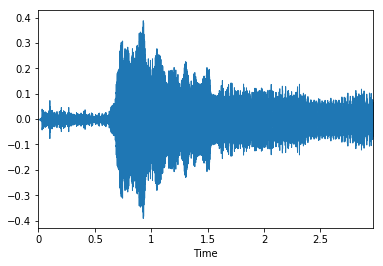

In [25]:
librosa.display.waveplot(y,sr)

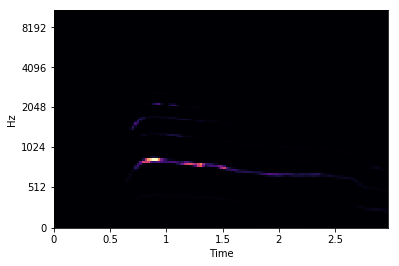

In [26]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [51]:
#for i in range(len(valid_train_data)):
#    valid_train_data['path'][0] = train_input['path'][0][3:]


#print ("sample",valid_train_data.path[1])
valid_train_data['path'] = train_input['path']
valid_train_data.head(5)

,path,label
0,../CatSound_dataset/Angry/car_extcoll0103.mp3,0
1,../CatSound_dataset/Angry/car_extcoll0104.mp3,0
2,../CatSound_dataset/Angry/car_extcoll0117.mp3,0
3,../CatSound_dataset/Angry/car_extcoll0128.mp3,0
4,../CatSound_dataset/Angry/car_extcoll0149.mp3,0


In [94]:
#
# set duration on audio loading to make audio content to ensure each training data have same size
# 
# for instance, 3 seconds audio will have 128*128 which will be use on this notebook
#
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

#fix the load audio file size
audio_play_duration=2.97

def load_audio_file(file_path, duration=2.97, sr=22050):

    input_length=sr*duration
    y, sr = librosa.load(file_path[3:],sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)
    if (round(dur) < duration):
        offset = len(y) - round(input_length)
        print ("fixing audio length :", file_path)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
        y = librosa.util.fix_length(y, round(input_length))         
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps

In [77]:
# %%time
# %%memit 
# Dataset
train_audio_data = [] 
train_object_file='saved_train_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(train_object_file):
    SKIP_AUDIO_RELOAD = False

#load training data
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TRAINING data from audio files")
else:
    print ("loading train audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row) )
    print("Number of train samples: ", len(train_audio_data))
# this step took sometime to finish    5382
#peak memory: 1141.30 MiB, increment: 642.16 MiB
#CPU times: user 15min 41s, sys: 14min 57s, total: 30min 39s

loading train audio data, may take more than 15 minutes. please wait!


29it [00:07,  3.68it/s]

fixing audio length : ../CatSound_dataset/Angry/cat02.mp3
input: 65489  load: 53568  offset: -11921


53it [00:14,  3.67it/s]

fixing audio length : ../CatSound_dataset/Angry/cat07.mp3
input: 65489  load: 50688  offset: -14801


58it [00:15,  3.67it/s]

fixing audio length : ../CatSound_dataset/Angry/cat14.mp3
input: 65489  load: 35136  offset: -30353


60it [00:16,  3.83it/s]

fixing audio length : ../CatSound_dataset/Angry/cat16.mp3
input: 65489  load: 40896  offset: -24593


61it [00:16,  3.93it/s]

fixing audio length : ../CatSound_dataset/Angry/cat17.mp3
input: 65489  load: 38592  offset: -26897


63it [00:16,  3.96it/s]

fixing audio length : ../CatSound_dataset/Angry/cat24.mp3
input: 65489  load: 51840  offset: -13649


74it [00:19,  3.82it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_angry1019.mp3
input: 65489  load: 40320  offset: -25169


76it [00:20,  3.89it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_angry1021.mp3
input: 65489  load: 47232  offset: -18257


77it [00:20,  3.97it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_angry1022.mp3
input: 65489  load: 47232  offset: -18257


78it [00:20,  4.00it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_angry1023.mp3
input: 65489  load: 45504  offset: -19985


80it [00:21,  4.02it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1026.mp3
input: 65489  load: 52416  offset: -13073


84it [00:22,  3.96it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1030.mp3
input: 65489  load: 52416  offset: -13073


85it [00:22,  3.94it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1031.mp3
input: 65489  load: 54720  offset: -10769


86it [00:22,  3.88it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1032.mp3
input: 65489  load: 50688  offset: -14801


87it [00:23,  3.94it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1033.mp3
input: 65489  load: 31680  offset: -33809


91it [00:24,  4.03it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1037.mp3
input: 65489  load: 51264  offset: -14225


92it [00:24,  4.00it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1038.mp3
input: 65489  load: 35136  offset: -30353


94it [00:24,  4.14it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1040.mp3
input: 65489  load: 51264  offset: -14225


96it [00:25,  4.08it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1043.mp3
input: 65489  load: 43776  offset: -21713


97it [00:25,  4.06it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1044.mp3
input: 65489  load: 39744  offset: -25745


98it [00:25,  4.12it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1045.mp3
input: 65489  load: 34560  offset: -30929


100it [00:26,  4.19it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1047.mp3
input: 65489  load: 54720  offset: -10769


101it [00:26,  4.06it/s]

fixing audio length : ../CatSound_dataset/Angry/Cat_Angry1048.mp3
input: 65489  load: 36288  offset: -29201


116it [00:30,  3.72it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01408.mp3
input: 65489  load: 53568  offset: -11921


118it [00:31,  3.68it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01416.mp3
input: 65489  load: 43776  offset: -21713


119it [00:31,  3.83it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01417.mp3
input: 65489  load: 43776  offset: -21713


121it [00:31,  3.91it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01420.mp3
input: 65489  load: 33984  offset: -31505


126it [00:33,  3.99it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01437.mp3
input: 65489  load: 50688  offset: -14801


129it [00:33,  3.86it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01441.mp3
input: 65489  load: 33984  offset: -31505


130it [00:34,  4.04it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01442.mp3
input: 65489  load: 52992  offset: -12497


131it [00:34,  4.01it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01446.mp3
input: 65489  load: 54144  offset: -11345


160it [00:42,  3.54it/s]

fixing audio length : ../CatSound_dataset/Angry/cat_flickr01504.mp3
input: 65489  load: 50112  offset: -15377


174it [00:45,  3.80it/s]

fixing audio length : ../CatSound_dataset/Angry/FIGHT_CONFUSION (3).mp3
input: 65489  load: 47808  offset: -17681


180it [00:47,  3.58it/s]

fixing audio length : ../CatSound_dataset/Angry/FIGHT_CONFUSION (9).mp3
input: 65489  load: 52416  offset: -13073


300it [01:19,  3.71it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0161.mp3
input: 65489  load: 36864  offset: -28625


303it [01:19,  3.91it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0166.mp3
input: 65489  load: 47232  offset: -18257


310it [01:21,  3.95it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0251.mp3
input: 65489  load: 29952  offset: -35537


311it [01:21,  4.09it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll02516.mp3
input: 65489  load: 33984  offset: -31505


312it [01:22,  4.22it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0255.mp3
input: 65489  load: 24768  offset: -40721


313it [01:22,  4.40it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0259.mp3
input: 65489  load: 26496  offset: -38993


314it [01:22,  4.47it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0263.mp3
input: 65489  load: 25920  offset: -39569


315it [01:22,  4.58it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0265.mp3
input: 65489  load: 23040  offset: -42449


316it [01:23,  4.70it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0268.mp3
input: 65489  load: 20160  offset: -45329


317it [01:23,  4.79it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0276.mp3
input: 65489  load: 26496  offset: -38993


318it [01:23,  4.81it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0287.mp3
input: 65489  load: 48384  offset: -17105


321it [01:24,  4.27it/s]

fixing audio length : ../CatSound_dataset/Defence/cat01.mp3
input: 65489  load: 48384  offset: -17105


322it [01:24,  4.15it/s]

fixing audio length : ../CatSound_dataset/Defence/cat04.mp3
input: 65489  load: 42624  offset: -22865


323it [01:24,  4.19it/s]

fixing audio length : ../CatSound_dataset/Defence/cat06.mp3
input: 65489  load: 34560  offset: -30929


325it [01:25,  4.27it/s]

fixing audio length : ../CatSound_dataset/Defence/cat08.mp3
input: 65489  load: 41472  offset: -24017


327it [01:25,  4.20it/s]

fixing audio length : ../CatSound_dataset/Defence/cat11.mp3
input: 65489  load: 51840  offset: -13649


329it [01:26,  4.10it/s]

fixing audio length : ../CatSound_dataset/Defence/Cathiss1010.mp3
input: 65489  load: 36288  offset: -29201


330it [01:26,  4.14it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr0105.mp3
input: 65489  load: 39168  offset: -26321


331it [01:26,  4.21it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr0124.mp3
input: 65489  load: 26496  offset: -38993


332it [01:26,  4.39it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01347.mp3
input: 65489  load: 35712  offset: -29777


333it [01:26,  4.43it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01351.mp3
input: 65489  load: 29952  offset: -35537


335it [01:27,  4.37it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01356.mp3
input: 65489  load: 29376  offset: -36113


336it [01:27,  4.36it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01364.mp3
input: 65489  load: 23616  offset: -41873


337it [01:27,  4.49it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01413.mp3
input: 65489  load: 25344  offset: -40145


338it [01:28,  4.59it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01440.mp3
input: 65489  load: 28224  offset: -37265


339it [01:28,  4.64it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01465.mp3
input: 65489  load: 36864  offset: -28625


340it [01:28,  4.54it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01468.mp3
input: 65489  load: 28800  offset: -36689


341it [01:28,  4.59it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01470.mp3
input: 65489  load: 30528  offset: -34961


342it [01:28,  4.59it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01471.mp3
input: 65489  load: 39168  offset: -26321


343it [01:29,  4.51it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr01473.mp3
input: 65489  load: 25920  offset: -39569


346it [01:29,  4.29it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr0155.mp3
input: 65489  load: 48960  offset: -16529


347it [01:30,  4.14it/s]

fixing audio length : ../CatSound_dataset/Defence/cat_flickr0156.mp3
input: 65489  load: 48960  offset: -16529


352it [01:31,  3.87it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hass1043.mp3
input: 65489  load: 31680  offset: -33809


353it [01:31,  4.07it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hass1050.mp3
input: 65489  load: 32832  offset: -32657


354it [01:31,  4.21it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hass1054.mp3
input: 65489  load: 40320  offset: -25169


355it [01:32,  4.25it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hass1066.mp3
input: 65489  load: 50112  offset: -15377


356it [01:32,  4.18it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_hiss.mp3
input: 65489  load: 21312  offset: -44177


357it [01:32,  4.40it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10010.mp3
input: 65489  load: 31104  offset: -34385


358it [01:32,  4.47it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10012.mp3
input: 65489  load: 24768  offset: -40721


359it [01:32,  4.60it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10013.mp3
input: 65489  load: 29376  offset: -36113


360it [01:33,  4.61it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10023.mp3
input: 65489  load: 36288  offset: -29201


361it [01:33,  4.57it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10024.mp3
input: 65489  load: 54144  offset: -11345


362it [01:33,  4.36it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10028.mp3
input: 65489  load: 38016  offset: -27473


363it [01:33,  4.35it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10031.mp3
input: 65489  load: 30528  offset: -34961


364it [01:34,  4.39it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10033.mp3
input: 65489  load: 35136  offset: -30353


365it [01:34,  4.42it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10034.mp3
input: 65489  load: 21312  offset: -44177


366it [01:34,  4.59it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10035.mp3
input: 65489  load: 42624  offset: -22865


367it [01:34,  4.49it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss10036.mp3
input: 65489  load: 50112  offset: -15377


368it [01:35,  4.36it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10038.mp3
input: 65489  load: 52416  offset: -13073


369it [01:35,  4.15it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10043.mp3
input: 65489  load: 52992  offset: -12497


370it [01:35,  4.09it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10044.mp3
input: 65489  load: 33984  offset: -31505


371it [01:35,  4.20it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10045.mp3
input: 65489  load: 51840  offset: -13649


372it [01:36,  4.13it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10047.mp3
input: 65489  load: 41472  offset: -24017


374it [01:36,  4.05it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10049.mp3
input: 65489  load: 49536  offset: -15953


375it [01:36,  4.01it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10051.mp3
input: 65489  load: 39168  offset: -26321


376it [01:37,  4.09it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10053.mp3
input: 65489  load: 25920  offset: -39569


378it [01:37,  4.09it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10055.mp3
input: 65489  load: 39168  offset: -26321


380it [01:37,  4.16it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10057.mp3
input: 65489  load: 52992  offset: -12497


381it [01:38,  4.03it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss10059.mp3
input: 65489  load: 31680  offset: -33809


389it [01:40,  3.92it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1041.mp3
input: 65489  load: 21312  offset: -44177


390it [01:40,  4.14it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss1051.mp3
input: 65489  load: 31680  offset: -33809


393it [01:41,  4.02it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1061.mp3
input: 65489  load: 38592  offset: -26897


394it [01:41,  4.05it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1065.mp3
input: 65489  load: 44928  offset: -20561


395it [01:41,  4.09it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1071.mp3
input: 65489  load: 27072  offset: -38417


396it [01:41,  4.28it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1073.mp3
input: 65489  load: 34560  offset: -30929


397it [01:42,  4.34it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1075.mp3
input: 65489  load: 52992  offset: -12497


398it [01:42,  4.23it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1077.mp3
input: 65489  load: 33408  offset: -32081


399it [01:42,  4.26it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1078.mp3
input: 65489  load: 50112  offset: -15377


400it [01:42,  4.17it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1083.mp3
input: 65489  load: 36288  offset: -29201


401it [01:43,  4.25it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1088.mp3
input: 65489  load: 37440  offset: -28049


402it [01:43,  4.32it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_HIss1093.mp3
input: 65489  load: 46080  offset: -19409


403it [01:43,  4.26it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1095.mp3
input: 65489  load: 43200  offset: -22289


404it [01:43,  4.25it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1096.mp3
input: 65489  load: 35136  offset: -30353


405it [01:43,  4.34it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hiss1097.mp3
input: 65489  load: 37440  offset: -28049


406it [01:44,  4.36it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_Hissing1025.mp3
input: 65489  load: 37440  offset: -28049


407it [01:44,  4.40it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42345.mp3
input: 65489  load: 36864  offset: -28625


409it [01:44,  4.18it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42357 (2).mp3
input: 65489  load: 25920  offset: -39569


410it [01:45,  4.30it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42359.mp3
input: 65489  load: 31104  offset: -34385


411it [01:45,  4.38it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42360.mp3
input: 65489  load: 40320  offset: -25169


412it [01:45,  4.38it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42361.mp3
input: 65489  load: 31104  offset: -34385


413it [01:45,  4.42it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42363.mp3
input: 65489  load: 41472  offset: -24017


415it [01:46,  4.12it/s]

fixing audio length : ../CatSound_dataset/Defence/Cat_YoutubeLLT42366 (2).mp3
input: 65489  load: 51264  offset: -14225


417it [01:46,  4.14it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9001Hiss (2).mp3
input: 65489  load: 23040  offset: -42449


418it [01:46,  4.30it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9001Hiss.mp3
input: 65489  load: 50112  offset: -15377


419it [01:47,  4.22it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9003Hiss.mp3
input: 65489  load: 21312  offset: -44177


420it [01:47,  4.42it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9006Hiss.mp3
input: 65489  load: 23040  offset: -42449


421it [01:47,  4.55it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9013Hiss.mp3
input: 65489  load: 28224  offset: -37265


422it [01:47,  4.63it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9014Hiss.mp3
input: 65489  load: 31104  offset: -34385


423it [01:48,  4.64it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9015Hiss.mp3
input: 65489  load: 31104  offset: -34385


424it [01:48,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9016Hiss.mp3
input: 65489  load: 28800  offset: -36689


425it [01:48,  4.68it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9017Hiss.mp3
input: 65489  load: 28800  offset: -36689


426it [01:48,  4.70it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9018Hiss.mp3
input: 65489  load: 44928  offset: -20561


427it [01:48,  4.55it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9019Hiss.mp3
input: 65489  load: 20736  offset: -44753


428it [01:49,  4.70it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9020Hiss.mp3
input: 65489  load: 22464  offset: -43025


429it [01:49,  4.78it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9021Hiss.mp3
input: 65489  load: 23040  offset: -42449


430it [01:49,  4.85it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9022Hiss.mp3
input: 65489  load: 17280  offset: -48209


431it [01:49,  4.93it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9024Hiss.mp3
input: 65489  load: 29952  offset: -35537


432it [01:49,  4.88it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9025Hiss.mp3
input: 65489  load: 17856  offset: -47633


433it [01:50,  4.97it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9027Hiss.mp3
input: 65489  load: 19008  offset: -46481


434it [01:50,  5.02it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9028Hiss.mp3
input: 65489  load: 33408  offset: -32081


435it [01:50,  4.88it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9029Hiss.mp3
input: 65489  load: 13824  offset: -51665


436it [01:50,  5.01it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9030Hiss.mp3
input: 65489  load: 22464  offset: -43025


437it [01:50,  5.00it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9031Hiss.mp3
input: 65489  load: 18432  offset: -47057


438it [01:51,  5.02it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9032Hiss.mp3
input: 65489  load: 23040  offset: -42449


439it [01:51,  5.02it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9033Hiss.mp3
input: 65489  load: 13248  offset: -52241


440it [01:51,  5.02it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9034Hiss.mp3
input: 65489  load: 17280  offset: -48209


441it [01:51,  5.09it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9035Hiss.mp3
input: 65489  load: 30528  offset: -34961


442it [01:51,  4.93it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9036Hiss.mp3
input: 65489  load: 15552  offset: -49937


443it [01:52,  5.01it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9038Hiss.mp3
input: 65489  load: 22464  offset: -43025


444it [01:52,  4.99it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9039Hiss.mp3
input: 65489  load: 48384  offset: -17105


445it [01:52,  4.69it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9040Hiss.mp3
input: 65489  load: 14400  offset: -51089


446it [01:52,  4.89it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9041Hiss.mp3
input: 65489  load: 27072  offset: -38417


447it [01:52,  4.86it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9042Hiss.mp3
input: 65489  load: 20736  offset: -44753


448it [01:53,  4.90it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9043Hiss.mp3
input: 65489  load: 20736  offset: -44753


449it [01:53,  4.93it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9044Hiss.mp3
input: 65489  load: 21888  offset: -43601


450it [01:53,  4.94it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9045Hiss.mp3
input: 65489  load: 23616  offset: -41873


451it [01:53,  4.93it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9046Hiss.mp3
input: 65489  load: 22464  offset: -43025


452it [01:53,  4.85it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9047Hiss.mp3
input: 65489  load: 48384  offset: -17105


453it [01:54,  4.56it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9048Hiss.mp3
input: 65489  load: 20736  offset: -44753


454it [01:54,  4.69it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9049Hiss.mp3
input: 65489  load: 16128  offset: -49361


455it [01:54,  4.77it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9050Hiss.mp3
input: 65489  load: 20160  offset: -45329


456it [01:54,  4.86it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9051Hiss.mp3
input: 65489  load: 16704  offset: -48785


457it [01:55,  4.97it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9053Hiss.mp3
input: 65489  load: 6912  offset: -58577


458it [01:55,  5.15it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9055Hiss.mp3
input: 65489  load: 25344  offset: -40145


459it [01:55,  5.07it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9056Hiss.mp3
input: 65489  load: 28224  offset: -37265


460it [01:55,  4.97it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9057Hiss.mp3
input: 65489  load: 34560  offset: -30929


461it [01:55,  4.83it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9058Hiss.mp3
input: 65489  load: 12672  offset: -52817


462it [01:56,  4.99it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9060Hiss.mp3
input: 65489  load: 24192  offset: -41297


463it [01:56,  4.96it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9061Hiss.mp3
input: 65489  load: 19584  offset: -45905


464it [01:56,  4.99it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9062Hiss.mp3
input: 65489  load: 16128  offset: -49361


465it [01:56,  5.05it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9063Hiss.mp3
input: 65489  load: 48384  offset: -17105


466it [01:56,  4.67it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9064Hiss.mp3
input: 65489  load: 22464  offset: -43025


467it [01:57,  4.75it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9065Hiss.mp3
input: 65489  load: 27648  offset: -37841


468it [01:57,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9066Hiss.mp3
input: 65489  load: 27072  offset: -38417


469it [01:57,  4.68it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9067Hiss.mp3
input: 65489  load: 39744  offset: -25745


470it [01:57,  4.56it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9068Hiss.mp3
input: 65489  load: 41472  offset: -24017


471it [01:57,  4.49it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9069Hiss.mp3
input: 65489  load: 29376  offset: -36113


472it [01:58,  4.54it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9070Hiss.mp3
input: 65489  load: 29952  offset: -35537


474it [01:58,  4.30it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9072Hiss.mp3
input: 65489  load: 16704  offset: -48785


475it [01:58,  4.53it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9073Hiss.mp3
input: 65489  load: 15552  offset: -49937


476it [01:59,  4.74it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9074Hiss.mp3
input: 65489  load: 13248  offset: -52241


477it [01:59,  4.92it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9075Hiss.mp3
input: 65489  load: 15552  offset: -49937


478it [01:59,  5.05it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9076Hiss.mp3
input: 65489  load: 12672  offset: -52817


479it [01:59,  5.17it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9078Hiss.mp3
input: 65489  load: 25344  offset: -40145


480it [01:59,  5.07it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9079Hiss.mp3
input: 65489  load: 19008  offset: -46481


481it [02:00,  5.08it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9080Hiss.mp3
input: 65489  load: 14976  offset: -50513


482it [02:00,  5.15it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9081Hiss.mp3
input: 65489  load: 19008  offset: -46481


483it [02:00,  5.12it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9112Hiss.mp3
input: 65489  load: 28800  offset: -36689


484it [02:00,  5.00it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9114Hiss.mp3
input: 65489  load: 14976  offset: -50513


485it [02:00,  5.06it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9115Hiss.mp3
input: 65489  load: 12672  offset: -52817


486it [02:00,  5.16it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9116Hiss.mp3
input: 65489  load: 42624  offset: -22865


487it [02:01,  4.86it/s]

fixing audio length : ../CatSound_dataset/Defence/Edit9119Hiss.mp3
input: 65489  load: 25920  offset: -39569


488it [02:01,  4.84it/s]

fixing audio length : ../CatSound_dataset/Defence/hiss.mp3
input: 65489  load: 29588  offset: -35901


489it [02:01,  4.78it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1001Hiss.mp3
input: 65489  load: 22464  offset: -43025


490it [02:01,  4.82it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1013Hiss.mp3
input: 65489  load: 35712  offset: -29777


491it [02:02,  4.68it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1017Hiss (2).mp3
input: 65489  load: 50112  offset: -15377


492it [02:02,  4.47it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1017Hiss.mp3
input: 65489  load: 49536  offset: -15953


493it [02:02,  4.34it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1042Hiss.mp3
input: 65489  load: 33408  offset: -32081


494it [02:02,  4.38it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1044Hiss.mp3
input: 65489  load: 44352  offset: -21137


495it [02:03,  4.34it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1045Hiss.mp3
input: 65489  load: 43776  offset: -21713


496it [02:03,  4.30it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1046Hiss.mp3
input: 65489  load: 54144  offset: -11345


497it [02:03,  4.18it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1047Hiss.mp3
input: 65489  load: 48960  offset: -16529


498it [02:03,  4.17it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1071Hiss (2).mp3
input: 65489  load: 48960  offset: -16529


503it [02:04,  4.11it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1077Hiss.mp3
input: 65489  load: 38016  offset: -27473


508it [02:06,  3.82it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1083Hiss (2).mp3
input: 65489  load: 25920  offset: -39569


509it [02:06,  3.99it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1083Hiss.mp3
input: 65489  load: 33408  offset: -32081


510it [02:06,  4.14it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1084Hiss.mp3
input: 65489  load: 40320  offset: -25169


511it [02:06,  4.19it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1089Hiss.mp3
input: 65489  load: 36864  offset: -28625


512it [02:07,  4.25it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1090Hiss (2).mp3
input: 65489  load: 23040  offset: -42449


513it [02:07,  4.43it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1090Hiss.mp3
input: 65489  load: 39168  offset: -26321


514it [02:07,  4.41it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1091Hiss.mp3
input: 65489  load: 29376  offset: -36113


515it [02:07,  4.49it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1092Hiss.mp3
input: 65489  load: 24768  offset: -40721


516it [02:08,  4.59it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1093Hiss.mp3
input: 65489  load: 28224  offset: -37265


517it [02:08,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1096Hiss.mp3
input: 65489  load: 33984  offset: -31505


518it [02:08,  4.63it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1097Hiss.mp3
input: 65489  load: 23616  offset: -41873


519it [02:08,  4.70it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1200Hiss.mp3
input: 65489  load: 33984  offset: -31505


520it [02:08,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1208Hiss.mp3
input: 65489  load: 21312  offset: -44177


521it [02:09,  4.74it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1287Hiss.mp3
input: 65489  load: 31680  offset: -33809


522it [02:09,  4.68it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1289Hiss.mp3
input: 65489  load: 19584  offset: -45905


523it [02:09,  4.81it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1291Hiss.mp3
input: 65489  load: 40320  offset: -25169


524it [02:09,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1292Hiss.mp3
input: 65489  load: 17280  offset: -48209


525it [02:09,  4.80it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1294Hiss.mp3
input: 65489  load: 33984  offset: -31505


526it [02:10,  4.69it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1299Hiss.mp3
input: 65489  load: 18432  offset: -47057


527it [02:10,  4.79it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1302Hiss.mp3
input: 65489  load: 33408  offset: -32081


528it [02:10,  4.72it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1305Hiss.mp3
input: 65489  load: 31680  offset: -33809


529it [02:10,  4.63it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1307Hiss.mp3
input: 65489  load: 19008  offset: -46481


530it [02:11,  4.78it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1311Hiss.mp3
input: 65489  load: 32256  offset: -33233


531it [02:11,  4.72it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1312Hiss.mp3
input: 65489  load: 41472  offset: -24017


532it [02:11,  4.61it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1314Hiss.mp3
input: 65489  load: 28224  offset: -37265


533it [02:11,  4.60it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1316Hiss.mp3
input: 65489  load: 25344  offset: -40145


534it [02:11,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1320Hiss.mp3
input: 65489  load: 19584  offset: -45905


535it [02:12,  4.78it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1321Hiss.mp3
input: 65489  load: 39168  offset: -26321


536it [02:12,  4.64it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1322Hiss.mp3
input: 65489  load: 16128  offset: -49361


537it [02:12,  4.78it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1324Hiss.mp3
input: 65489  load: 24192  offset: -41297


538it [02:12,  4.81it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1325Hiss.mp3
input: 65489  load: 13824  offset: -51665


539it [02:12,  4.93it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1326Hiss.mp3
input: 65489  load: 14976  offset: -50513


540it [02:13,  5.00it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1327Hiss.mp3
input: 65489  load: 26496  offset: -38993


541it [02:13,  4.92it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1329Hiss.mp3
input: 65489  load: 29952  offset: -35537


542it [02:13,  4.84it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1330Hiss.mp3
input: 65489  load: 21312  offset: -44177


543it [02:13,  4.89it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1332Hiss.mp3
input: 65489  load: 18432  offset: -47057


544it [02:13,  4.90it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1335Hiss.mp3
input: 65489  load: 31680  offset: -33809


545it [02:14,  4.82it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1337Hiss.mp3
input: 65489  load: 42048  offset: -23441


546it [02:14,  4.65it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1339Hiss.mp3
input: 65489  load: 23040  offset: -42449


547it [02:14,  4.71it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1341Hiss.mp3
input: 65489  load: 16704  offset: -48785


548it [02:14,  4.84it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1343Hiss.mp3
input: 65489  load: 28800  offset: -36689


549it [02:14,  4.81it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1345Hiss.mp3
input: 65489  load: 23040  offset: -42449


550it [02:15,  4.84it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1347Hiss.mp3
input: 65489  load: 35136  offset: -30353


551it [02:15,  4.71it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1349Hiss.mp3
input: 65489  load: 24192  offset: -41297


552it [02:15,  4.76it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1352Hiss.mp3
input: 65489  load: 28224  offset: -37265


553it [02:15,  4.71it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1355Hiss.mp3
input: 65489  load: 38592  offset: -26897


554it [02:16,  4.45it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1357Hiss.mp3
input: 65489  load: 18432  offset: -47057


555it [02:16,  4.56it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1360Hiss.mp3
input: 65489  load: 19584  offset: -45905


556it [02:16,  4.62it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1363Grl (2).mp3
input: 65489  load: 28800  offset: -36689


557it [02:16,  4.58it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1363Hiss (2).mp3
input: 65489  load: 21312  offset: -44177


558it [02:16,  4.66it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1363Hiss (3).mp3
input: 65489  load: 19008  offset: -46481


559it [02:17,  4.74it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1363Hiss.mp3
input: 65489  load: 23616  offset: -41873


561it [02:17,  4.35it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1367Hiss (2).mp3
input: 65489  load: 28800  offset: -36689


562it [02:17,  4.42it/s]

fixing audio length : ../CatSound_dataset/Defence/LastEntry_cat1367Hiss.mp3
input: 65489  load: 16704  offset: -48785


563it [02:18,  4.61it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat101Hiss.mp3
input: 65489  load: 33984  offset: -31505


564it [02:18,  4.56it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat104Hiss.mp3
input: 65489  load: 34560  offset: -30929


565it [02:18,  4.53it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat109Hiss.mp3
input: 65489  load: 24192  offset: -41297


566it [02:18,  4.60it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat252hiss.mp3
input: 65489  load: 25920  offset: -39569


567it [02:18,  4.64it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat259His.mp3
input: 65489  load: 37440  offset: -28049


568it [02:19,  4.50it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat274Hiss.mp3
input: 65489  load: 51264  offset: -14225


569it [02:19,  4.33it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat275Hiss.mp3
input: 65489  load: 32256  offset: -33233


570it [02:19,  4.40it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat276Hiss.mp3
input: 65489  load: 52992  offset: -12497


571it [02:19,  4.23it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat277Hiss.mp3
input: 65489  load: 32256  offset: -33233


572it [02:20,  4.26it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat286Hiss.mp3
input: 65489  load: 22464  offset: -43025


573it [02:20,  4.41it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat290Hiss.mp3
input: 65489  load: 35712  offset: -29777


574it [02:20,  4.35it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat291Hiss.mp3
input: 65489  load: 25920  offset: -39569


575it [02:20,  4.45it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat331Hiss.mp3
input: 65489  load: 34560  offset: -30929


576it [02:20,  4.39it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat334Hiss.mp3
input: 65489  load: 48960  offset: -16529


577it [02:21,  4.22it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat338Hiss.mp3
input: 65489  load: 23616  offset: -41873


578it [02:21,  4.37it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat341Hiss.mp3
input: 65489  load: 20736  offset: -44753


579it [02:21,  4.45it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat348Hiss.mp3
input: 65489  load: 23616  offset: -41873


580it [02:21,  4.55it/s]

fixing audio length : ../CatSound_dataset/Defence/Last_addCat354Hiss.mp3
input: 65489  load: 27072  offset: -38417


581it [02:22,  4.62it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0294hiss.mp3
input: 65489  load: 25920  offset: -39569


582it [02:22,  4.63it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0296Hiss.mp3
input: 65489  load: 33408  offset: -32081


583it [02:22,  4.56it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0297Hiss.mp3
input: 65489  load: 32256  offset: -33233


584it [02:22,  4.56it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0299Hiss.mp3
input: 65489  load: 32832  offset: -32657


585it [02:22,  4.58it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0303Hiss.mp3
input: 65489  load: 19584  offset: -45905


586it [02:23,  4.64it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0384hiss.mp3
input: 65489  load: 26808  offset: -38681


587it [02:23,  4.68it/s]

fixing audio length : ../CatSound_dataset/Defence/Online_Cat0457his.mp3
input: 65489  load: 44928  offset: -20561


588it [02:23,  4.51it/s]

fixing audio length : ../CatSound_dataset/Defence/YashLL_Cat0223Hiss.mp3
input: 65489  load: 29952  offset: -35537


589it [02:23,  4.55it/s]

fixing audio length : ../CatSound_dataset/Fighting/angry4.mp3
input: 65489  load: 31992  offset: -33497


591it [02:24,  4.43it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0102.mp3
input: 65489  load: 45504  offset: -19985


593it [02:24,  4.20it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0142.mp3
input: 65489  load: 27072  offset: -38417


594it [02:25,  4.30it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0143.mp3
input: 65489  load: 28800  offset: -36689


600it [02:26,  3.96it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0222.mp3
input: 65489  load: 44352  offset: -21137


606it [02:28,  3.83it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0253.mp3
input: 65489  load: 54144  offset: -11345


607it [02:28,  3.87it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0256.mp3
input: 65489  load: 33408  offset: -32081


609it [02:28,  4.06it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0260.mp3
input: 65489  load: 42048  offset: -23441


610it [02:29,  4.07it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0262.mp3
input: 65489  load: 43200  offset: -22289


615it [02:30,  3.69it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0272.mp3
input: 65489  load: 48384  offset: -17105


616it [02:30,  3.75it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0275.mp3
input: 65489  load: 32832  offset: -32657


620it [02:31,  3.89it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0301.mp3
input: 65489  load: 46080  offset: -19409


621it [02:31,  3.91it/s]

fixing audio length : ../CatSound_dataset/Fighting/CAT (1).mp3
input: 65489  load: 27342  offset: -38147


632it [02:34,  3.79it/s]

fixing audio length : ../CatSound_dataset/Fighting/cat0333.mp3
input: 65489  load: 48384  offset: -17105


633it [02:35,  3.86it/s]

fixing audio length : ../CatSound_dataset/Fighting/cat0334.mp3
input: 65489  load: 47232  offset: -18257


663it [02:42,  3.83it/s]

fixing audio length : ../CatSound_dataset/Fighting/Edit9023fit.mp3
input: 65489  load: 29376  offset: -36113


664it [02:43,  4.06it/s]

fixing audio length : ../CatSound_dataset/Fighting/Edit9025Fit.mp3
input: 65489  load: 41472  offset: -24017


665it [02:43,  4.11it/s]

fixing audio length : ../CatSound_dataset/Fighting/Edit9120Fit.mp3
input: 65489  load: 44928  offset: -20561


675it [02:45,  3.82it/s]

fixing audio length : ../CatSound_dataset/Fighting/LastEntry_cat1300Fit.mp3
input: 65489  load: 35136  offset: -30353


677it [02:46,  3.95it/s]

fixing audio length : ../CatSound_dataset/Fighting/LastEntry_cat1306Fit.mp3
input: 65489  load: 44352  offset: -21137


680it [02:47,  3.78it/s]

fixing audio length : ../CatSound_dataset/Fighting/LastEntry_cat1319Fit.mp3
input: 65489  load: 50112  offset: -15377


684it [02:48,  3.89it/s]

fixing audio length : ../CatSound_dataset/Fighting/Last_addCat113Fit.mp3
input: 65489  load: 41472  offset: -24017


686it [02:48,  4.02it/s]

fixing audio length : ../CatSound_dataset/Fighting/Last_addCat115Fit.mp3
input: 65489  load: 47808  offset: -17681


687it [02:48,  3.96it/s]

fixing audio length : ../CatSound_dataset/Fighting/Last_addCat116Fit.mp3
input: 65489  load: 45504  offset: -19985


692it [02:50,  3.88it/s]

fixing audio length : ../CatSound_dataset/Fighting/Last_addCat254fit.mp3
input: 65489  load: 37440  offset: -28049


713it [02:55,  3.64it/s]

fixing audio length : ../CatSound_dataset/Fighting/Last_addCat317Fit.mp3
input: 65489  load: 43776  offset: -21713


722it [02:58,  3.81it/s]

fixing audio length : ../CatSound_dataset/Fighting/Last_addCat364Fit.mp3
input: 65489  load: 50112  offset: -15377


724it [02:58,  3.69it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0292.mp3
input: 65489  load: 36864  offset: -28625


728it [02:59,  3.86it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0323ang.mp3
input: 65489  load: 33720  offset: -31769


732it [03:00,  3.96it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0328fit.mp3
input: 65489  load: 53568  offset: -11921


733it [03:00,  3.93it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0330Ang.mp3
input: 65489  load: 53304  offset: -12185


734it [03:01,  3.94it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0334ang.mp3
input: 65489  load: 44100  offset: -21389


735it [03:01,  4.00it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0335Ang.mp3
input: 65489  load: 39480  offset: -26009


736it [03:01,  4.06it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0341Ang.mp3
input: 65489  load: 52728  offset: -12761


737it [03:01,  4.01it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0350Ang.mp3
input: 65489  load: 42360  offset: -23129


738it [03:02,  4.03it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0356ang.mp3
input: 65489  load: 27960  offset: -37529


740it [03:02,  4.18it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0363fit.mp3
input: 65489  load: 37752  offset: -27737


741it [03:02,  4.17it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0367Ang.mp3
input: 65489  load: 26808  offset: -38681


742it [03:03,  4.33it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0367fit.mp3
input: 65489  load: 31992  offset: -33497


743it [03:03,  4.39it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0369fit.mp3
input: 65489  load: 17280  offset: -48209


744it [03:03,  4.55it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0382Ang.mp3
input: 65489  load: 36600  offset: -28889


745it [03:03,  4.51it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0383fit.mp3
input: 65489  load: 45240  offset: -20249


747it [03:04,  4.31it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0436fit.mp3
input: 65489  load: 38904  offset: -26585


748it [03:04,  4.25it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0437fit.mp3
input: 65489  load: 36600  offset: -28889


749it [03:04,  4.27it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0438fit.mp3
input: 65489  load: 52728  offset: -12761


750it [03:04,  4.16it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0439Fit.mp3
input: 65489  load: 39480  offset: -26009


752it [03:05,  4.03it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0441Fit.mp3
input: 65489  load: 36600  offset: -28889


753it [03:05,  4.11it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0443Fit.mp3
input: 65489  load: 39480  offset: -26009


757it [03:06,  3.67it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0466Fit.mp3
input: 65489  load: 53304  offset: -12185


760it [03:07,  3.90it/s]

fixing audio length : ../CatSound_dataset/Fighting/Online_Cat0498Ang.mp3
input: 65489  load: 18168  offset: -47321


770it [03:10,  3.55it/s]

fixing audio length : ../CatSound_dataset/Fighting/quick fight.mp3
input: 65489  load: 19845  offset: -45644


771it [03:10,  3.87it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0214Fit (2).mp3
input: 65489  load: 37440  offset: -28049


789it [03:15,  3.60it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0239Fit.mp3
input: 65489  load: 52992  offset: -12497


803it [03:19,  3.34it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0249Fit.mp3
input: 65489  load: 49536  offset: -15953


804it [03:19,  3.45it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0250Fight.mp3
input: 65489  load: 51264  offset: -14225


828it [03:26,  3.58it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0286Fit.mp3
input: 65489  load: 46656  offset: -18833


829it [03:26,  3.70it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0287Fit.mp3
input: 65489  load: 51840  offset: -13649


832it [03:27,  3.71it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0290Fit.mp3
input: 65489  load: 54144  offset: -11345


834it [03:28,  3.61it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0296Fit.mp3
input: 65489  load: 47232  offset: -18257


835it [03:28,  3.77it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0298Fit.mp3
input: 65489  load: 39744  offset: -25745


845it [03:31,  3.58it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0911Fit.mp3
input: 65489  load: 40320  offset: -25169


846it [03:31,  3.76it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_Cat0913Fit.mp3
input: 65489  load: 51840  offset: -13649


866it [03:36,  3.58it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_CONF_Cat0261Fit (12).mp3
input: 65489  load: 51264  offset: -14225


869it [03:37,  3.71it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_CONF_Cat0261Fit (15).mp3
input: 65489  load: 39744  offset: -25745


878it [03:40,  3.62it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_CONF_Cat0261Fit (23).mp3
input: 65489  load: 45504  offset: -19985


881it [03:40,  3.84it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_CONF_Cat0261Fit (4).mp3
input: 65489  load: 41472  offset: -24017


886it [03:42,  3.70it/s]

fixing audio length : ../CatSound_dataset/Fighting/YashLL_CONF_Cat0261Fit (9).mp3
input: 65489  load: 48384  offset: -17105


887it [03:42,  3.78it/s]

fixing audio length : ../CatSound_dataset/Happy/1294_1256854279.mp3
input: 65489  load: 19843  offset: -45646


888it [03:42,  4.06it/s]

fixing audio length : ../CatSound_dataset/Happy/1295_1256854283.mp3
input: 65489  load: 20002  offset: -45487


889it [03:42,  4.29it/s]

fixing audio length : ../CatSound_dataset/Happy/1296_1256854286.mp3
input: 65489  load: 15267  offset: -50222


891it [03:43,  4.16it/s]

fixing audio length : ../CatSound_dataset/Happy/agressive.mp3
input: 65489  load: 18168  offset: -47321


892it [03:43,  4.40it/s]

fixing audio length : ../CatSound_dataset/Happy/ANIM1027.mp3
input: 65489  load: 13560  offset: -51929


893it [03:43,  4.62it/s]

fixing audio length : ../CatSound_dataset/Happy/car_extcoll0261.mp3
input: 65489  load: 20736  offset: -44753


894it [03:43,  4.72it/s]

fixing audio length : ../CatSound_dataset/Happy/Cat (2).mp3
input: 65489  load: 32256  offset: -33233


895it [03:44,  5.03it/s]

fixing audio length : ../CatSound_dataset/Happy/cat01.mp3
input: 65489  load: 19008  offset: -46481


896it [03:44,  5.04it/s]

fixing audio length : ../CatSound_dataset/Happy/cat010.mp3
input: 65489  load: 37440  offset: -28049


897it [03:44,  4.67it/s]

fixing audio length : ../CatSound_dataset/Happy/cat011.mp3
input: 65489  load: 35136  offset: -30353


898it [03:44,  4.57it/s]

fixing audio length : ../CatSound_dataset/Happy/cat01101.mp3
input: 65489  load: 37440  offset: -28049


908it [03:47,  3.61it/s]

fixing audio length : ../CatSound_dataset/Happy/cat01102.mp3
input: 65489  load: 39168  offset: -26321


916it [03:49,  3.63it/s]

fixing audio length : ../CatSound_dataset/Happy/cat011029.mp3
input: 65489  load: 29376  offset: -36113


918it [03:50,  3.88it/s]

fixing audio length : ../CatSound_dataset/Happy/cat011030.mp3
input: 65489  load: 27072  offset: -38417


926it [03:52,  3.89it/s]

fixing audio length : ../CatSound_dataset/Happy/cat02.mp3
input: 65489  load: 37440  offset: -28049


927it [03:52,  4.00it/s]

fixing audio length : ../CatSound_dataset/Happy/cat03.mp3
input: 65489  load: 25344  offset: -40145


928it [03:52,  4.17it/s]

fixing audio length : ../CatSound_dataset/Happy/cat04.mp3
input: 65489  load: 33408  offset: -32081


929it [03:52,  4.25it/s]

fixing audio length : ../CatSound_dataset/Happy/cat04nn.mp3
input: 65489  load: 23616  offset: -41873


930it [03:53,  4.46it/s]

fixing audio length : ../CatSound_dataset/Happy/cat05.mp3
input: 65489  load: 28800  offset: -36689


931it [03:53,  4.59it/s]

fixing audio length : ../CatSound_dataset/Happy/cat06.mp3
input: 65489  load: 36864  offset: -28625


932it [03:53,  4.48it/s]

fixing audio length : ../CatSound_dataset/Happy/cat07.mp3
input: 65489  load: 36864  offset: -28625


933it [03:53,  4.51it/s]

fixing audio length : ../CatSound_dataset/Happy/cat08.mp3
input: 65489  load: 20160  offset: -45329


934it [03:53,  4.63it/s]

fixing audio length : ../CatSound_dataset/Happy/cat09.mp3
input: 65489  load: 36288  offset: -29201


935it [03:54,  4.61it/s]

fixing audio length : ../CatSound_dataset/Happy/cat10.mp3
input: 65489  load: 28800  offset: -36689


936it [03:54,  4.65it/s]

fixing audio length : ../CatSound_dataset/Happy/cat12.mp3
input: 65489  load: 20160  offset: -45329


957it [04:00,  3.75it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_100.mp3
input: 65489  load: 29112  offset: -36377


959it [04:00,  3.81it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_110.mp3
input: 65489  load: 28536  offset: -36953


962it [04:01,  3.72it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_124.mp3
input: 65489  load: 24504  offset: -40985


964it [04:01,  3.59it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_133.mp3
input: 65489  load: 31416  offset: -34073


965it [04:02,  3.79it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_134.mp3
input: 65489  load: 28536  offset: -36953


966it [04:02,  3.99it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_135.mp3
input: 65489  load: 27384  offset: -38105


968it [04:02,  3.97it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_137.mp3
input: 65489  load: 23352  offset: -42137


969it [04:03,  4.14it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_138.mp3
input: 65489  load: 27960  offset: -37529


970it [04:03,  4.20it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_139.mp3
input: 65489  load: 21624  offset: -43865


971it [04:03,  4.32it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_140.mp3
input: 65489  load: 21624  offset: -43865


973it [04:04,  4.12it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_155.mp3
input: 65489  load: 43512  offset: -21977


974it [04:04,  4.06it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_156.mp3
input: 65489  load: 46968  offset: -18521


975it [04:04,  4.05it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_158.mp3
input: 65489  load: 34872  offset: -30617


976it [04:04,  4.17it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_18.mp3
input: 65489  load: 29688  offset: -35801


977it [04:04,  4.28it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_20.mp3
input: 65489  load: 39480  offset: -26009


979it [04:05,  4.06it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_4.mp3
input: 65489  load: 36024  offset: -29465


981it [04:05,  4.04it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_53.mp3
input: 65489  load: 26808  offset: -38681


982it [04:06,  4.20it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_54.mp3
input: 65489  load: 24504  offset: -40985


983it [04:06,  4.37it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_67.mp3
input: 65489  load: 22200  offset: -43289


984it [04:06,  4.32it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_68.mp3
input: 65489  load: 52728  offset: -12761


986it [04:07,  3.87it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_76.mp3
input: 65489  load: 43512  offset: -21977


987it [04:07,  3.95it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_8.mp3
input: 65489  load: 33144  offset: -32345


988it [04:07,  4.10it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_85.mp3
input: 65489  load: 24504  offset: -40985


989it [04:07,  4.32it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_86.mp3
input: 65489  load: 39480  offset: -26009


990it [04:08,  4.39it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_9.mp3
input: 65489  load: 22200  offset: -43289


991it [04:08,  4.54it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_91.mp3
input: 65489  load: 26232  offset: -39257


992it [04:08,  4.60it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_coll0101.mp3
input: 65489  load: 54720  offset: -10769


1000it [04:10,  3.62it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_coll0126.mp3
input: 65489  load: 51264  offset: -14225


1003it [04:11,  3.71it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_coll0130.mp3
input: 65489  load: 44928  offset: -20561


1004it [04:11,  3.80it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_coll0131.mp3
input: 65489  load: 53568  offset: -11921


1007it [04:12,  3.84it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_coll0158.mp3
input: 65489  load: 40896  offset: -24593


1010it [04:13,  3.79it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_flickr0111.mp3
input: 65489  load: 28800  offset: -36689


1012it [04:13,  4.09it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_flickr01324.mp3
input: 65489  load: 38592  offset: -26897


1014it [04:14,  3.89it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_flickr01337.mp3
input: 65489  load: 44928  offset: -20561


1021it [04:16,  3.82it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_flickr0187.mp3
input: 65489  load: 35712  offset: -29777


1030it [04:18,  3.54it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_youtube01113.mp3
input: 65489  load: 42048  offset: -23441


1033it [04:19,  3.59it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_youtube01123.mp3
input: 65489  load: 36288  offset: -29201


1034it [04:19,  3.67it/s]

fixing audio length : ../CatSound_dataset/Happy/cat_youtube01124.mp3
input: 65489  load: 50112  offset: -15377


1054it [04:25,  3.51it/s]

fixing audio length : ../CatSound_dataset/Happy/Cat_YoutubeLLT42389.mp3
input: 65489  load: 50112  offset: -15377


1056it [04:25,  3.53it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9006Hpy.mp3
input: 65489  load: 43776  offset: -21713


1057it [04:26,  3.66it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9082Hpy (2).mp3
input: 65489  load: 23616  offset: -41873


1058it [04:26,  3.95it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9082Hpy.mp3
input: 65489  load: 50688  offset: -14801


1062it [04:27,  3.69it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9085Hpy.mp3
input: 65489  load: 45504  offset: -19985


1064it [04:28,  3.76it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9087Hpy.mp3
input: 65489  load: 33984  offset: -31505


1066it [04:28,  3.79it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9089Hpy.mp3
input: 65489  load: 36864  offset: -28625


1067it [04:28,  3.91it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9090Hpy.mp3
input: 65489  load: 48384  offset: -17105


1068it [04:29,  3.88it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9091Hpy.mp3
input: 65489  load: 42624  offset: -22865


1069it [04:29,  3.91it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9092Hpy.mp3
input: 65489  load: 32832  offset: -32657


1070it [04:29,  4.03it/s]

fixing audio length : ../CatSound_dataset/Happy/Edit9093Hpy.mp3
input: 65489  load: 26496  offset: -38993


1075it [04:30,  3.83it/s]

fixing audio length : ../CatSound_dataset/Happy/hpy.mp3
input: 65489  load: 35136  offset: -30353


1076it [04:31,  3.98it/s]

fixing audio length : ../CatSound_dataset/Happy/hpy9.mp3
input: 65489  load: 27072  offset: -38417


1077it [04:31,  4.16it/s]

fixing audio length : ../CatSound_dataset/Happy/LastEntry_cat1018Hpy.mp3
input: 65489  load: 46080  offset: -19409


1084it [04:33,  3.75it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0293.mp3
input: 65489  load: 33984  offset: -31505


1087it [04:33,  3.70it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0329hpy.mp3
input: 65489  load: 49272  offset: -16217


1088it [04:34,  3.73it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0331hpy.mp3
input: 65489  load: 14136  offset: -51353


1089it [04:34,  4.04it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0332hpy.mp3
input: 65489  load: 44100  offset: -21389


1090it [04:34,  3.98it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0333hpy.mp3
input: 65489  load: 44100  offset: -21389


1091it [04:34,  3.92it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0336hpy.mp3
input: 65489  load: 48960  offset: -16529


1093it [04:35,  4.08it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0338hpy.mp3
input: 65489  load: 28536  offset: -36953


1094it [04:35,  4.22it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0339hpy.mp3
input: 65489  load: 11832  offset: -53657


1098it [04:36,  3.87it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0345hpy.mp3
input: 65489  load: 18744  offset: -46745


1099it [04:36,  4.14it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0346hpy.mp3
input: 65489  load: 12408  offset: -53081


1102it [04:37,  3.82it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0349hpy.mp3
input: 65489  load: 35512  offset: -29977


1103it [04:37,  3.93it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0350hpy.mp3
input: 65489  load: 21624  offset: -43865


1104it [04:38,  4.16it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0351hpy.mp3
input: 65489  load: 27384  offset: -38105


1107it [04:38,  4.00it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0359Hpy.mp3
input: 65489  load: 17592  offset: -47897


1108it [04:39,  4.29it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0360hpy.mp3
input: 65489  load: 19320  offset: -46169


1112it [04:40,  3.73it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0370hpy.mp3
input: 65489  load: 51000  offset: -14489


1113it [04:40,  3.78it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0371hpy.mp3
input: 65489  load: 40632  offset: -24857


1117it [04:41,  3.65it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0376hpy.mp3
input: 65489  load: 22776  offset: -42713


1118it [04:41,  3.89it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0377hpy.mp3
input: 65489  load: 15288  offset: -50201


1119it [04:41,  4.11it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0379hpy.mp3
input: 65489  load: 18168  offset: -47321


1120it [04:42,  4.37it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0380hpy.mp3
input: 65489  load: 14136  offset: -51353


1121it [04:42,  4.55it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0386Hpy.mp3
input: 65489  load: 12984  offset: -52505


1124it [04:43,  3.94it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0391Hpy.mp3
input: 65489  load: 15864  offset: -49625


1128it [04:44,  3.93it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0394Hpy.mp3
input: 65489  load: 25080  offset: -40409


1131it [04:44,  3.48it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0397Hpy.mp3
input: 65489  load: 31104  offset: -34385


1132it [04:45,  3.72it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0398Hpy.mp3
input: 65489  load: 20472  offset: -45017


1135it [04:45,  3.71it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0402hpy.mp3
input: 65489  load: 23352  offset: -42137


1136it [04:46,  4.07it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0403hpy.mp3
input: 65489  load: 44352  offset: -21137


1137it [04:46,  4.14it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0404hpy.mp3
input: 65489  load: 26808  offset: -38681


1140it [04:47,  3.92it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0407hpy.mp3
input: 65489  load: 20472  offset: -45017


1147it [04:49,  3.79it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0449Hpy.mp3
input: 65489  load: 18168  offset: -47321


1148it [04:49,  4.10it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0458hpy.mp3
input: 65489  load: 24504  offset: -40985


1153it [04:50,  3.90it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0467Hpy.mp3
input: 65489  load: 28536  offset: -36953


1155it [04:50,  4.07it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0472Hpy.mp3
input: 65489  load: 12672  offset: -52817


1156it [04:51,  4.31it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0477Hpy.mp3
input: 65489  load: 44100  offset: -21389


1159it [04:51,  3.94it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0481hpy.mp3
input: 65489  load: 20160  offset: -45329


1160it [04:52,  4.43it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0482hpy.mp3
input: 65489  load: 53568  offset: -11921


1161it [04:52,  4.88it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0483hpy.mp3
input: 65489  load: 44352  offset: -21137


1162it [04:52,  5.30it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0494Hpy.mp3
input: 65489  load: 15864  offset: -49625


1163it [04:52,  5.24it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0495Hpy.mp3
input: 65489  load: 53304  offset: -12185


1164it [04:52,  4.71it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0496Hpy.mp3
input: 65489  load: 44088  offset: -21401


1165it [04:53,  4.59it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0497Hpy.mp3
input: 65489  load: 14712  offset: -50777


1166it [04:53,  4.79it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0499Hpy.mp3
input: 65489  load: 44664  offset: -20825


1167it [04:53,  4.58it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0500Hpy.mp3
input: 65489  load: 13560  offset: -51929


1168it [04:53,  4.89it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0502Hpy.mp3
input: 65489  load: 11832  offset: -53657


1169it [04:53,  4.90it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0503Hpy.mp3
input: 65489  load: 18744  offset: -46745


1170it [04:54,  4.93it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0504Hpy.mp3
input: 65489  load: 13560  offset: -51929


1171it [04:54,  5.05it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0505Hpy.mp3
input: 65489  load: 19896  offset: -45593


1172it [04:54,  5.05it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0506Hpy.mp3
input: 65489  load: 17016  offset: -48473


1173it [04:54,  5.12it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0507Hpy.mp3
input: 65489  load: 14136  offset: -51353


1174it [04:54,  5.18it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0509Hpy.mp3
input: 65489  load: 25080  offset: -40409


1175it [04:55,  5.16it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0512Hpy.mp3
input: 65489  load: 14136  offset: -51353


1176it [04:55,  5.21it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0513Hpy.mp3
input: 65489  load: 15864  offset: -49625


1177it [04:55,  5.25it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0514Hpy.mp3
input: 65489  load: 19896  offset: -45593


1178it [04:55,  5.21it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0516Hpy.mp3
input: 65489  load: 35136  offset: -30353


1180it [04:56,  4.48it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0537Hpy.mp3
input: 65489  load: 22776  offset: -42713


1181it [04:56,  4.71it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0539Hpy.mp3
input: 65489  load: 21048  offset: -44441


1182it [04:56,  4.87it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0540Hpy.mp3
input: 65489  load: 22200  offset: -43289


1183it [04:56,  4.86it/s]

fixing audio length : ../CatSound_dataset/Happy/Online_Cat0546Hpy.mp3
input: 65489  load: 32568  offset: -32921


1186it [04:57,  4.18it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/car_extcoll0328.mp3
input: 65489  load: 35712  offset: -29777


1187it [04:57,  4.21it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/car_extcoll0329.mp3
input: 65489  load: 54720  offset: -10769


1191it [04:58,  3.97it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat01.mp3
input: 65489  load: 52416  offset: -13073


1194it [04:59,  3.84it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat0202.mp3
input: 65489  load: 33408  offset: -32081


1212it [05:04,  3.80it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter024.mp3
input: 65489  load: 54720  offset: -10769


1233it [05:09,  3.76it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter345.mp3
input: 65489  load: 51264  offset: -14225


1235it [05:10,  3.91it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter347.mp3
input: 65489  load: 45504  offset: -19985


1236it [05:10,  4.00it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter448.mp3
input: 65489  load: 42624  offset: -22865


1242it [05:12,  3.93it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter656.mp3
input: 65489  load: 53568  offset: -11921


1243it [05:12,  4.03it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter657.mp3
input: 65489  load: 23040  offset: -42449


1244it [05:12,  4.23it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter658.mp3
input: 65489  load: 52992  offset: -12497


1247it [05:13,  4.09it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter661.mp3
input: 65489  load: 54144  offset: -11345


1253it [05:14,  3.75it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/catchatter767.mp3
input: 65489  load: 33408  offset: -32081


1276it [05:20,  3.65it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat_youtube01147.mp3
input: 65489  load: 43776  offset: -21713


1282it [05:22,  3.80it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat_youtube01156.mp3
input: 65489  load: 52992  offset: -12497


1300it [05:27,  3.53it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat_youtube01175.mp3
input: 65489  load: 52992  offset: -12497


1317it [05:31,  3.72it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat_youtube01272.mp3
input: 65489  load: 47808  offset: -17681


1325it [05:34,  3.56it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat_youtube01280.mp3
input: 65489  load: 41472  offset: -24017


1327it [05:34,  3.69it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/Cat_YoutubeLLT42391.mp3
input: 65489  load: 48384  offset: -17105


1344it [05:39,  3.76it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/Cat_YoutubeLLT42409.mp3
input: 65489  load: 47232  offset: -18257


1389it [05:51,  3.47it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/Last_addCat129595Chat.mp3
input: 65489  load: 50112  offset: -15377


1394it [05:52,  3.67it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/Last_addCat167Chat.mp3
input: 65489  load: 44928  offset: -20561


1399it [05:53,  3.83it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/Last_addCat172Chat.mp3
input: 65489  load: 52992  offset: -12497


1432it [06:02,  3.70it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/Last_addCat229Chat.mp3
input: 65489  load: 43776  offset: -21713


1461it [06:10,  3.83it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/trill02987.mp3
input: 65489  load: 51840  offset: -13649


1463it [06:11,  3.84it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/trill02989.mp3
input: 65489  load: 41472  offset: -24017


1464it [06:11,  3.95it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/trill029892.mp3
input: 65489  load: 49536  offset: -15953


1784it [07:39,  3.71it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat025.mp3
input: 65489  load: 50112  offset: -15377


1785it [07:39,  3.81it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat026.mp3
input: 65489  load: 47232  offset: -18257


1787it [07:39,  3.89it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat028.mp3
input: 65489  load: 52992  offset: -12497


1795it [07:42,  3.59it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_19.mp3
input: 65489  load: 28536  offset: -36953


1801it [07:43,  3.83it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_coll0142.mp3
input: 65489  load: 48384  offset: -17105


1802it [07:43,  3.96it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_coll01813.mp3
input: 65489  load: 40896  offset: -24593


1811it [07:46,  3.89it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_edit03023pill.mp3
input: 65489  load: 19008  offset: -46481


1813it [07:46,  3.99it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_flickr01296.mp3
input: 65489  load: 47232  offset: -18257


1814it [07:46,  4.02it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_flickr01297.mp3
input: 65489  load: 49536  offset: -15953


1817it [07:47,  3.85it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_flickr01300.mp3
input: 65489  load: 51264  offset: -14225


1820it [07:48,  3.92it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_flickr0185.mp3
input: 65489  load: 42048  offset: -23441


1826it [07:50,  3.72it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Cat_pills0115.mp3
input: 65489  load: 51840  offset: -13649


1831it [07:51,  3.93it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Cat_pills0120.mp3
input: 65489  load: 52416  offset: -13073


1856it [07:57,  3.69it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Cat_pills0145.mp3
input: 65489  load: 50688  offset: -14801


1857it [07:58,  3.85it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Cat_pills0146.mp3
input: 65489  load: 46656  offset: -18833


1858it [07:58,  3.97it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Cat_pills0147.mp3
input: 65489  load: 40320  offset: -25169


1861it [07:59,  3.74it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Cat_pills0150.mp3
input: 65489  load: 47808  offset: -17681


1912it [08:13,  3.64it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_youtube01220.mp3
input: 65489  load: 51264  offset: -14225


1920it [08:15,  3.64it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_youtube01229.mp3
input: 65489  load: 52416  offset: -13073


1928it [08:17,  3.75it/s]

fixing audio length : ../CatSound_dataset/MotherCall/cat_youtube01240.mp3
input: 65489  load: 41472  offset: -24017


1963it [08:26,  3.74it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Edit9107Pill.mp3
input: 65489  load: 41472  offset: -24017


2052it [08:50,  3.70it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0399Pill.mp3
input: 65489  load: 46080  offset: -19409


2053it [08:51,  3.91it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0412pil.mp3
input: 65489  load: 45504  offset: -19985


2054it [08:51,  3.96it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0447Pil.mp3
input: 65489  load: 54144  offset: -11345


2055it [08:51,  4.15it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0448Pil.mp3
input: 65489  load: 50074  offset: -15415


2056it [08:51,  4.18it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0485Pil.mp3
input: 65489  load: 40320  offset: -25169


2057it [08:52,  4.33it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0487Pil.mp3
input: 65489  load: 28800  offset: -36689


2058it [08:52,  4.62it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0488Pil.mp3
input: 65489  load: 12672  offset: -52817


2059it [08:52,  5.04it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0489Pill.mp3
input: 65489  load: 50424  offset: -15065


2060it [08:52,  4.66it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0490Pill.mp3
input: 65489  load: 29952  offset: -35537


2061it [08:52,  4.88it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0491Pill.mp3
input: 65489  load: 27072  offset: -38417


2063it [08:53,  4.42it/s]

fixing audio length : ../CatSound_dataset/MotherCall/Online_Cat0510Pill.mp3
input: 65489  load: 12642  offset: -52847


2065it [08:53,  4.73it/s]

fixing audio length : ../CatSound_dataset/Paining/angry2.mp3
input: 65489  load: 32568  offset: -32921


2067it [08:54,  4.52it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0147.mp3
input: 65489  load: 35712  offset: -29777


2068it [08:54,  4.45it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0148.mp3
input: 65489  load: 47808  offset: -17681


2071it [08:55,  3.94it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0188.mp3
input: 65489  load: 35136  offset: -30353


2074it [08:55,  3.87it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0247.mp3
input: 65489  load: 46080  offset: -19409


2075it [08:56,  3.95it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0336.mp3
input: 65489  load: 40896  offset: -24593


2076it [08:56,  4.09it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0337.mp3
input: 65489  load: 54144  offset: -11345


2077it [08:56,  4.03it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0338.mp3
input: 65489  load: 54144  offset: -11345


2085it [08:58,  3.77it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0346.mp3
input: 65489  load: 38592  offset: -26897


2086it [08:58,  3.96it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0347.mp3
input: 65489  load: 36864  offset: -28625


2094it [09:01,  3.83it/s]

fixing audio length : ../CatSound_dataset/Paining/Cat meow animals021.mp3
input: 65489  load: 35448  offset: -30041


2095it [09:01,  3.95it/s]

fixing audio length : ../CatSound_dataset/Paining/cat01.mp3
input: 65489  load: 42048  offset: -23441


2097it [09:01,  3.95it/s]

fixing audio length : ../CatSound_dataset/Paining/cat018.mp3
input: 65489  load: 48960  offset: -16529


2099it [09:02,  4.01it/s]

fixing audio length : ../CatSound_dataset/Paining/cat03.mp3
input: 65489  load: 40896  offset: -24593


2101it [09:02,  4.13it/s]

fixing audio length : ../CatSound_dataset/Paining/cat05.mp3
input: 65489  load: 22464  offset: -43025


2102it [09:02,  4.37it/s]

fixing audio length : ../CatSound_dataset/Paining/cat06.mp3
input: 65489  load: 26496  offset: -38993


2103it [09:03,  4.58it/s]

fixing audio length : ../CatSound_dataset/Paining/cat07.mp3
input: 65489  load: 29952  offset: -35537


2104it [09:03,  4.58it/s]

fixing audio length : ../CatSound_dataset/Paining/cat08.mp3
input: 65489  load: 23040  offset: -42449


2105it [09:03,  4.68it/s]

fixing audio length : ../CatSound_dataset/Paining/cat09.mp3
input: 65489  load: 36864  offset: -28625


2107it [09:04,  4.42it/s]

fixing audio length : ../CatSound_dataset/Paining/cat11.mp3
input: 65489  load: 48384  offset: -17105


2112it [09:05,  3.78it/s]

fixing audio length : ../CatSound_dataset/Paining/cat16.mp3
input: 65489  load: 46656  offset: -18833


2113it [09:05,  3.77it/s]

fixing audio length : ../CatSound_dataset/Paining/cat17.mp3
input: 65489  load: 38592  offset: -26897


2115it [09:06,  3.86it/s]

fixing audio length : ../CatSound_dataset/Paining/cat19.mp3
input: 65489  load: 47232  offset: -18257


2117it [09:06,  3.86it/s]

fixing audio length : ../CatSound_dataset/Paining/cat21.mp3
input: 65489  load: 24768  offset: -40721


2123it [09:08,  3.84it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0150.mp3
input: 65489  load: 40320  offset: -25169


2124it [09:08,  3.91it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0151.mp3
input: 65489  load: 35136  offset: -30353


2125it [09:08,  4.09it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0152.mp3
input: 65489  load: 42624  offset: -22865


2127it [09:09,  3.97it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0154.mp3
input: 65489  load: 47232  offset: -18257


2130it [09:09,  3.93it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0157.mp3
input: 65489  load: 47232  offset: -18257


2131it [09:10,  3.98it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0160.mp3
input: 65489  load: 28800  offset: -36689


2132it [09:10,  4.22it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0164.mp3
input: 65489  load: 31104  offset: -34385


2145it [09:13,  3.76it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0177.mp3
input: 65489  load: 34560  offset: -30929


2146it [09:14,  3.99it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_coll0178.mp3
input: 65489  load: 28800  offset: -36689


2148it [09:14,  4.13it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_flickr0118.mp3
input: 65489  load: 54144  offset: -11345


2152it [09:15,  3.81it/s]

fixing audio length : ../CatSound_dataset/Paining/cat_flickr01301.mp3
input: 65489  load: 50112  offset: -15377


2206it [09:30,  3.72it/s]

fixing audio length : ../CatSound_dataset/Paining/Cat_YoutubeLLT42380.mp3
input: 65489  load: 28800  offset: -36689


2207it [09:30,  4.01it/s]

fixing audio length : ../CatSound_dataset/Paining/Cat_YoutubeLLT42381.mp3
input: 65489  load: 43776  offset: -21713


2209it [09:30,  3.93it/s]

fixing audio length : ../CatSound_dataset/Paining/Cat_YoutubeLLT42383.mp3
input: 65489  load: 44928  offset: -20561


2210it [09:30,  4.08it/s]

fixing audio length : ../CatSound_dataset/Paining/Cat_YoutubeLLT42384.mp3
input: 65489  load: 52416  offset: -13073


2214it [09:32,  3.85it/s]

fixing audio length : ../CatSound_dataset/Paining/Cat_YoutubeLLT42388.mp3
input: 65489  load: 52992  offset: -12497


2226it [09:35,  3.88it/s]

fixing audio length : ../CatSound_dataset/Paining/Edit9007Hlp.mp3
input: 65489  load: 24192  offset: -41297


2227it [09:35,  4.05it/s]

fixing audio length : ../CatSound_dataset/Paining/Edit9008Hlp.mp3
input: 65489  load: 39168  offset: -26321


2231it [09:36,  3.87it/s]

fixing audio length : ../CatSound_dataset/Paining/Edit9098Hlp.mp3
input: 65489  load: 32256  offset: -33233


2253it [09:42,  3.72it/s]

fixing audio length : ../CatSound_dataset/Paining/Last_addCat129568Res.mp3
input: 65489  load: 48384  offset: -17105


2276it [09:48,  3.57it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0303Help.mp3
input: 65489  load: 54720  offset: -10769


2283it [09:50,  3.78it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0314hpy.mp3
input: 65489  load: 23352  offset: -42137


2284it [09:50,  4.05it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0315hpy.mp3
input: 65489  load: 23352  offset: -42137


2285it [09:50,  4.34it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0320hpy.mp3
input: 65489  load: 22200  offset: -43289


2286it [09:50,  4.53it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0325help.mp3
input: 65489  load: 52992  offset: -12497


2288it [09:51,  4.29it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0326hpy.mp3
input: 65489  load: 35448  offset: -30041


2289it [09:51,  4.32it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0327help.mp3
input: 65489  load: 53304  offset: -12185


2292it [09:52,  4.08it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0330hlp.mp3
input: 65489  load: 53304  offset: -12185


2293it [09:52,  4.05it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0336ffhpy.mp3
input: 65489  load: 25656  offset: -39833


2297it [09:53,  3.86it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0358hpy.mp3
input: 65489  load: 32568  offset: -32921


2299it [09:54,  3.92it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0368ang.mp3
input: 65489  load: 52728  offset: -12761


2301it [09:54,  3.96it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0384hpy.mp3
input: 65489  load: 35448  offset: -30041


2306it [09:55,  3.77it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0465hpy.mp3
input: 65489  load: 17016  offset: -48473


2310it [09:56,  3.88it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0475Hpy.mp3
input: 65489  load: 31416  offset: -34073


2313it [09:57,  4.22it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0493Hlp.mp3
input: 65489  load: 31746  offset: -33743


2314it [09:57,  4.45it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0501Hlp.mp3
input: 65489  load: 51264  offset: -14225


2317it [09:58,  3.92it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0515Hlp.mp3
input: 65489  load: 19404  offset: -46085


2318it [09:58,  4.18it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0518Hlp.mp3
input: 65489  load: 48120  offset: -17369


2319it [09:58,  4.20it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0519Hpy.mp3
input: 65489  load: 32568  offset: -32921


2320it [09:59,  4.30it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0520Hlp.mp3
input: 65489  load: 26808  offset: -38681


2321it [09:59,  4.51it/s]

fixing audio length : ../CatSound_dataset/Paining/Online_Cat0521Hlp.mp3
input: 65489  load: 26808  offset: -38681


2332it [10:02,  3.73it/s]

fixing audio length : ../CatSound_dataset/Paining/Pain326.mp3
input: 65489  load: 38016  offset: -27473


2339it [10:04,  3.74it/s]

fixing audio length : ../CatSound_dataset/Paining/Pain333.mp3
input: 65489  load: 44352  offset: -21137


2343it [10:05,  3.71it/s]

fixing audio length : ../CatSound_dataset/Paining/Pain337.mp3
input: 65489  load: 43776  offset: -21713


2344it [10:05,  3.86it/s]

fixing audio length : ../CatSound_dataset/Paining/Pain338.mp3
input: 65489  load: 50688  offset: -14801


2345it [10:05,  3.78it/s]

fixing audio length : ../CatSound_dataset/Paining/Pain340.mp3
input: 65489  load: 39744  offset: -25745


2369it [10:11,  3.69it/s]

fixing audio length : ../CatSound_dataset/Resting/cat13.mp3
input: 65489  load: 48384  offset: -17105


2456it [10:35,  3.70it/s]

fixing audio length : ../CatSound_dataset/Resting/cat_flickr01376.mp3
input: 65489  load: 53568  offset: -11921


2517it [10:51,  3.65it/s]

fixing audio length : ../CatSound_dataset/Resting/cat_youtube01305.mp3
input: 65489  load: 52992  offset: -12497


2553it [11:01,  3.74it/s]

fixing audio length : ../CatSound_dataset/Resting/LastEntry_cat1213Purr.mp3
input: 65489  load: 35712  offset: -29777


2636it [11:23,  3.78it/s]

fixing audio length : ../CatSound_dataset/Resting/purr02995.mp3
input: 65489  load: 47808  offset: -17681


2639it [11:24,  3.71it/s]

fixing audio length : ../CatSound_dataset/Resting/purr10.mp3
input: 65489  load: 21888  offset: -43601


2652it [11:27,  3.70it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0178.mp3
input: 65489  load: 50112  offset: -15377


2660it [11:29,  3.74it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0243.mp3
input: 65489  load: 53568  offset: -11921


2663it [11:30,  3.80it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0271.mp3
input: 65489  load: 32256  offset: -33233


2665it [11:31,  3.81it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0278.mp3
input: 65489  load: 42624  offset: -22865


2666it [11:31,  3.85it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0279.mp3
input: 65489  load: 44928  offset: -20561


2667it [11:31,  4.00it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0280.mp3
input: 65489  load: 33408  offset: -32081


2669it [11:32,  4.14it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0282.mp3
input: 65489  load: 37440  offset: -28049


2670it [11:32,  4.25it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0283.mp3
input: 65489  load: 47232  offset: -18257


2694it [11:38,  3.82it/s]

fixing audio length : ../CatSound_dataset/Warning/cat02.mp3
input: 65489  load: 52992  offset: -12497


2703it [11:41,  3.65it/s]

fixing audio length : ../CatSound_dataset/Warning/Catgrow0112.mp3
input: 65489  load: 42048  offset: -23441


2708it [11:42,  3.77it/s]

fixing audio length : ../CatSound_dataset/Warning/Cat_Angry1050.mp3
input: 65489  load: 29952  offset: -35537


2715it [11:44,  3.79it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr0126.mp3
input: 65489  load: 40320  offset: -25169


2717it [11:44,  3.85it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr0128.mp3
input: 65489  load: 54720  offset: -10769


2718it [11:44,  3.90it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr0129.mp3
input: 65489  load: 28800  offset: -36689


2719it [11:45,  4.13it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr0130.mp3
input: 65489  load: 51264  offset: -14225


2720it [11:45,  4.03it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01308.mp3
input: 65489  load: 31104  offset: -34385


2721it [11:45,  4.25it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01309.mp3
input: 65489  load: 52992  offset: -12497


2722it [11:45,  4.17it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01311.mp3
input: 65489  load: 35136  offset: -30353


2723it [11:46,  4.28it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01313.mp3
input: 65489  load: 39744  offset: -25745


2725it [11:46,  4.23it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01346.mp3
input: 65489  load: 52992  offset: -12497


2730it [11:47,  3.87it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01354.mp3
input: 65489  load: 40896  offset: -24593


2735it [11:49,  4.02it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01361.mp3
input: 65489  load: 48384  offset: -17105


2745it [11:51,  3.78it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01409.mp3
input: 65489  load: 48384  offset: -17105


2746it [11:52,  3.89it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01410.mp3
input: 65489  load: 47232  offset: -18257


2749it [11:52,  3.91it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01418.mp3
input: 65489  load: 32832  offset: -32657


2750it [11:52,  4.14it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01423.mp3
input: 65489  load: 50688  offset: -14801


2751it [11:53,  4.18it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01424.mp3
input: 65489  load: 49536  offset: -15953


2752it [11:53,  4.10it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01426.mp3
input: 65489  load: 54720  offset: -10769


2753it [11:53,  4.08it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01427.mp3
input: 65489  load: 54720  offset: -10769


2754it [11:53,  3.98it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01428.mp3
input: 65489  load: 47232  offset: -18257


2755it [11:54,  4.05it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01429.mp3
input: 65489  load: 32832  offset: -32657


2756it [11:54,  4.20it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01432.mp3
input: 65489  load: 46080  offset: -19409


2757it [11:54,  4.14it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01433.mp3
input: 65489  load: 44928  offset: -20561


2765it [11:56,  3.63it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01457.mp3
input: 65489  load: 44352  offset: -21137


2773it [11:59,  3.67it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_flickr01475.mp3
input: 65489  load: 33408  offset: -32081


2777it [12:00,  3.68it/s]

fixing audio length : ../CatSound_dataset/Warning/Cat_Growing1082.mp3
input: 65489  load: 34560  offset: -30929


2779it [12:00,  3.94it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_Growl011.mp3
input: 65489  load: 54144  offset: -11345


2784it [12:01,  3.80it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_Growl016.mp3
input: 65489  load: 46656  offset: -18833


2785it [12:02,  3.98it/s]

fixing audio length : ../CatSound_dataset/Warning/cat_Growl017.mp3
input: 65489  load: 47808  offset: -17681


2788it [12:02,  3.86it/s]

fixing audio length : ../CatSound_dataset/Warning/Cat_Growl1062.mp3
input: 65489  load: 50112  offset: -15377


2824it [12:12,  3.66it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9009Grl.mp3
input: 65489  load: 32832  offset: -32657


2825it [12:12,  3.89it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9025Grl.mp3
input: 65489  load: 49536  offset: -15953


2826it [12:13,  3.96it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9026Grl.mp3
input: 65489  load: 39744  offset: -25745


2827it [12:13,  3.98it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9031Grl.mp3
input: 65489  load: 28800  offset: -36689


2828it [12:13,  4.29it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9037Grl.mp3
input: 65489  load: 47808  offset: -17681


2829it [12:13,  4.20it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9052Grl.mp3
input: 65489  load: 39744  offset: -25745


2830it [12:14,  4.25it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9054Grl.mp3
input: 65489  load: 51264  offset: -14225


2831it [12:14,  4.18it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9056Grl.mp3
input: 65489  load: 22464  offset: -43025


2832it [12:14,  4.31it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9059Grl.mp3
input: 65489  load: 23616  offset: -41873


2833it [12:14,  4.44it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9061Grl.mp3
input: 65489  load: 33408  offset: -32081


2834it [12:14,  4.48it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9077Grl.mp3
input: 65489  load: 27072  offset: -38417


2836it [12:15,  4.30it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9095Grl.mp3
input: 65489  load: 48384  offset: -17105


2845it [12:17,  3.97it/s]

fixing audio length : ../CatSound_dataset/Warning/Edit9120Grl.mp3
input: 65489  load: 32832  offset: -32657


2847it [12:18,  3.79it/s]

fixing audio length : ../CatSound_dataset/Warning/grl5.mp3
input: 65489  load: 46080  offset: -19409


2857it [12:21,  3.58it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1018Grl.mp3
input: 65489  load: 40320  offset: -25169


2872it [12:24,  3.87it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1298Grl.mp3
input: 65489  load: 43776  offset: -21713


2877it [12:26,  3.82it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1318Grl.mp3
input: 65489  load: 37440  offset: -28049


2878it [12:26,  3.96it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1328Grl.mp3
input: 65489  load: 54720  offset: -10769


2880it [12:26,  4.06it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1334Grl.mp3
input: 65489  load: 33408  offset: -32081


2883it [12:27,  3.95it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1338Grl.mp3
input: 65489  load: 38016  offset: -27473


2886it [12:28,  3.75it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1344Grl.mp3
input: 65489  load: 44928  offset: -20561


2889it [12:29,  3.81it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1349Grl.mp3
input: 65489  load: 38016  offset: -27473


2893it [12:30,  3.82it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1354Grl.mp3
input: 65489  load: 43776  offset: -21713


2894it [12:30,  3.85it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1356Grl.mp3
input: 65489  load: 51840  offset: -13649


2895it [12:30,  3.94it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1358Grl.mp3
input: 65489  load: 39168  offset: -26321


2896it [12:31,  4.03it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1359Grl.mp3
input: 65489  load: 33408  offset: -32081


2897it [12:31,  4.17it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1361Grl.mp3
input: 65489  load: 54720  offset: -10769


2898it [12:31,  4.09it/s]

fixing audio length : ../CatSound_dataset/Warning/LastEntry_cat1362Grl.mp3
input: 65489  load: 51840  offset: -13649


2904it [12:33,  3.81it/s]

fixing audio length : ../CatSound_dataset/Warning/Last_addCat129592Grl (2).mp3
input: 65489  load: 50688  offset: -14801


2905it [12:33,  3.94it/s]

fixing audio length : ../CatSound_dataset/Warning/Last_addCat129592Grl (3).mp3
input: 65489  load: 42624  offset: -22865


2921it [12:37,  3.66it/s]

fixing audio length : ../CatSound_dataset/Warning/Last_addCat345Grl.mp3
input: 65489  load: 53568  offset: -11921


2935it [12:41,  3.77it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0310grl.mp3
input: 65489  load: 27960  offset: -37529


2936it [12:41,  4.01it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0311grl.mp3
input: 65489  load: 20472  offset: -45017


2937it [12:41,  4.34it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0312grl.mp3
input: 65489  load: 45240  offset: -20249


2938it [12:42,  4.26it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0313grl.mp3
input: 65489  load: 36024  offset: -29465


2939it [12:42,  4.35it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0320ang.mp3
input: 65489  load: 32568  offset: -32921


2940it [12:42,  4.41it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0320grl.mp3
input: 65489  load: 16440  offset: -49049


2949it [12:44,  3.64it/s]

fixing audio length : ../CatSound_dataset/Warning/Online_Cat0469Grl.mp3
input: 65489  load: 35868  offset: -29621


2950it [12:45,  3.90it/s]


Number of train samples:  2698


In [88]:
# load saved audio object


if SKIP_AUDIO_RELOAD is True:
    train_audio_data = cPickle.load(open(train_object_file, 'rb'))
    print ("loaded train data [%s] records from object file" % len(train_audio_data))  
else:
    cPickle.dump(train_audio_data, open(train_object_file, 'wb')) 
    print ("saved loaded train data :",len(train_audio_data))

PicklingError: Can't pickle <class 'pandas.core.frame.Pandas'>: attribute lookup Pandas on pandas.core.frame failed

In [95]:
%%time
%%memit 


#load test data
test_audio_data = []
test_object_file='saved_test_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(test_object_file):
    SKIP_AUDIO_RELOAD = False

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("loading test audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_test_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128):
            print ("***data shape is wrong, replace it with zeros ", ps.shape, row.path)
            ps = np.zeros([128, 128])
            #continue
        test_audio_data.append( (ps, row.label) ) 
    print("Number of train samples: ", len(train_audio_data))
    
# this step took sometime to finish    3251
#peak memory: 1586.96 MiB, increment: 445.65 MiB
#CPU times: user 9min 32s, sys: 9min 37s, total: 19min 10s

loading test audio data, may take more than 15 minutes. please wait!


5it [00:01,  3.55it/s]

***data shape is wrong, replace it with zeros  (128, 118) ../CatSound_dataset/Angry/car_extcoll0150.mp3


6it [00:01,  3.60it/s]

***data shape is wrong, replace it with zeros  (128, 124) ../CatSound_dataset/Angry/car_extcoll0151.mp3


12it [00:03,  3.54it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0161.mp3
input: 65489  load: 36864  offset: -28625


13it [00:03,  3.75it/s]

***data shape is wrong, replace it with zeros  (128, 119) ../CatSound_dataset/Defence/car_extcoll0164.mp3


15it [00:04,  3.72it/s]

fixing audio length : ../CatSound_dataset/Defence/car_extcoll0166.mp3
input: 65489  load: 47232  offset: -18257


16it [00:04,  3.82it/s]

***data shape is wrong, replace it with zeros  (128, 127) ../CatSound_dataset/Defence/car_extcoll0168.mp3


22it [00:06,  3.64it/s]

fixing audio length : ../CatSound_dataset/Fighting/angry4.mp3
input: 65489  load: 31992  offset: -33497


23it [00:06,  3.85it/s]

***data shape is wrong, replace it with zeros  (128, 120) ../CatSound_dataset/Fighting/car_extcoll0101.mp3


24it [00:06,  3.82it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0102.mp3
input: 65489  load: 45504  offset: -19985


25it [00:06,  3.85it/s]

***data shape is wrong, replace it with zeros  (128, 110) ../CatSound_dataset/Fighting/car_extcoll0136.mp3


26it [00:07,  3.85it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0142.mp3
input: 65489  load: 27072  offset: -38417


27it [00:07,  4.04it/s]

fixing audio length : ../CatSound_dataset/Fighting/car_extcoll0143.mp3
input: 65489  load: 28800  offset: -36689


29it [00:07,  3.86it/s]

***data shape is wrong, replace it with zeros  (128, 111) ../CatSound_dataset/Fighting/car_extcoll0160.mp3


33it [00:08,  3.82it/s]

fixing audio length : ../CatSound_dataset/Happy/1294_1256854279.mp3
input: 65489  load: 19843  offset: -45646


34it [00:09,  4.05it/s]

fixing audio length : ../CatSound_dataset/Happy/1295_1256854283.mp3
input: 65489  load: 20002  offset: -45487


35it [00:09,  4.21it/s]

fixing audio length : ../CatSound_dataset/Happy/1296_1256854286.mp3
input: 65489  load: 15267  offset: -50222


37it [00:09,  4.02it/s]

fixing audio length : ../CatSound_dataset/Happy/agressive.mp3
input: 65489  load: 18168  offset: -47321


38it [00:09,  4.24it/s]

fixing audio length : ../CatSound_dataset/Happy/ANIM1027.mp3
input: 65489  load: 13560  offset: -51929


39it [00:10,  4.46it/s]

fixing audio length : ../CatSound_dataset/Happy/car_extcoll0261.mp3
input: 65489  load: 20736  offset: -44753


40it [00:10,  4.51it/s]

fixing audio length : ../CatSound_dataset/Happy/Cat (2).mp3
input: 65489  load: 32256  offset: -33233


41it [00:10,  4.86it/s]

fixing audio length : ../CatSound_dataset/Happy/cat01.mp3
input: 65489  load: 19008  offset: -46481


42it [00:10,  4.83it/s]

fixing audio length : ../CatSound_dataset/Happy/cat010.mp3
input: 65489  load: 37440  offset: -28049


43it [00:11,  4.59it/s]

fixing audio length : ../CatSound_dataset/Happy/cat011.mp3
input: 65489  load: 35136  offset: -30353


44it [00:11,  4.48it/s]

***data shape is wrong, replace it with zeros  (128, 125) ../CatSound_dataset/HuntingMind/car_extcoll0326.mp3


46it [00:11,  3.96it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/car_extcoll0328.mp3
input: 65489  load: 35712  offset: -29777


47it [00:12,  4.08it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/car_extcoll0329.mp3
input: 65489  load: 54720  offset: -10769


49it [00:12,  3.79it/s]

***data shape is wrong, replace it with zeros  (128, 118) ../CatSound_dataset/HuntingMind/car_extcoll0331.mp3


50it [00:12,  3.75it/s]

***data shape is wrong, replace it with zeros  (128, 123) ../CatSound_dataset/HuntingMind/car_extcoll0332.mp3


51it [00:13,  3.73it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat01.mp3
input: 65489  load: 52416  offset: -13073


54it [00:13,  3.65it/s]

fixing audio length : ../CatSound_dataset/HuntingMind/cat0202.mp3
input: 65489  load: 33408  offset: -32081


57it [00:14,  3.68it/s]

***data shape is wrong, replace it with zeros  (128, 118) ../CatSound_dataset/Mating/cat011.mp3


73it [00:19,  3.50it/s]

***data shape is wrong, replace it with zeros  (128, 114) ../CatSound_dataset/MotherCall/cat017.mp3


74it [00:19,  3.61it/s]

***data shape is wrong, replace it with zeros  (128, 116) ../CatSound_dataset/MotherCall/cat019.mp3


78it [00:20,  3.87it/s]

fixing audio length : ../CatSound_dataset/Paining/angry2.mp3
input: 65489  load: 32568  offset: -32921


79it [00:20,  3.99it/s]

***data shape is wrong, replace it with zeros  (128, 114) ../CatSound_dataset/Paining/car_extcoll0146.mp3


80it [00:21,  3.90it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0147.mp3
input: 65489  load: 35712  offset: -29777


81it [00:21,  3.97it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0148.mp3
input: 65489  load: 47808  offset: -17681


84it [00:22,  3.67it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0188.mp3
input: 65489  load: 35136  offset: -30353


87it [00:23,  3.61it/s]

fixing audio length : ../CatSound_dataset/Paining/car_extcoll0247.mp3
input: 65489  load: 46080  offset: -19409


89it [00:23,  3.58it/s]

***data shape is wrong, replace it with zeros  (128, 125) ../CatSound_dataset/Resting/cat010.mp3


93it [00:24,  3.50it/s]

***data shape is wrong, replace it with zeros  (128, 111) ../CatSound_dataset/Resting/cat05.mp3


100it [00:26,  3.45it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0178.mp3
input: 65489  load: 50112  offset: -15377


101it [00:26,  3.58it/s]

***data shape is wrong, replace it with zeros  (128, 127) ../CatSound_dataset/Warning/car_extcoll0182.mp3


108it [00:28,  3.71it/s]

fixing audio length : ../CatSound_dataset/Warning/car_extcoll0243.mp3
input: 65489  load: 53568  offset: -11921


110it [00:29,  3.75it/s]


Number of train samples:  2698
peak memory: 599.07 MiB, increment: 16.62 MiB
Wall time: 30.1 s


In [96]:
# load saved data
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 110


In [384]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from numpy import argmax

# get a set of unique text labels
list_labels = sorted(list(set(valid_train_data.path.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(valid_train_data.path.values, valid_train_data.label.values)}

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
#print ("test label to int ",label_to_int["Applause"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}

unique text labels count:  2950


labels:  ['../CatSound_dataset/Angry/Cat_Angry1026.mp3', '../CatSound_dataset/Angry/Cat_Angry1027.mp3', '../CatSound_dataset/Angry/Cat_Angry1028.mp3', '../CatSound_dataset/Angry/Cat_Angry1029.mp3', '../CatSound_dataset/Angry/Cat_Angry1030.mp3', '../CatSound_dataset/Angry/Cat_Angry1031.mp3', '../CatSound_dataset/Angry/Cat_Angry1032.mp3', '../CatSound_dataset/Angry/Cat_Angry1033.mp3', '../CatSound_dataset/Angry/Cat_Angry1034.mp3', '../CatSound_dataset/Angry/Cat_Angry1035.mp3', '../CatSound_dataset/Angry/Cat_Angry1036.mp3', '../CatSound_dataset/Angry/Cat_Angry1037.mp3', '../CatSound_dataset/Angry/Cat_Angry1038.mp3', '../CatSound_dataset/Angry/Cat_Angry1039.mp3', '../CatSound_dataset/Angry/Cat_Angry1040.mp3', '../CatSound_dataset/Angry/Cat_Angry1042.mp3', '../CatSound_dataset/Angry/Cat_Angry1043.mp3', '../CatSound_dataset/Angry/Cat_Angry1044.mp3', '../CatSound_dataset/Angry/Cat_Angry1045.mp3', '../CatSound_dataset/Angry/Cat_Angry1046.mp3', '../CatSound_dataset/Angry/Cat_Angry1047.mp3', '..

encoded labelint values [   0    1    2 ... 2947 2948 2949]


In [385]:
#full dataset
dataset = train_audio_data
random.shuffle(dataset)

RATIO=0.8
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]



In [378]:
train


X_train, y_train = zip(*train)
X_test, y_test = zip(*test)


# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (2158, 128, 128, 1) 2158
test  (540, 128, 128, 1) 540


In [388]:
y_test

array([['1460', '../CatSound_dataset/HuntingMind/trill02986.mp3', '4'],
       ['346', '../CatSound_dataset/Defence/cat_flickr0155.mp3', '1'],
       ['1641', '../CatSound_dataset/Mating/cat_youtube64368.mp3', '5'],
       ...,
       ['1989', '../CatSound_dataset/MotherCall/Last_addCat134Pil.mp3',
        '6'],
       ['2809', '../CatSound_dataset/Warning/cat_youtube64301 (2).mp3',
        '9'],
       ['1934', '../CatSound_dataset/MotherCall/Cat_YoutubeLLT42313.mp3',
        '6']], dtype='<U60')

In [389]:
y_train

array([['1436',
        '../CatSound_dataset/HuntingMind/Last_addCat232Chat4.mp3', '4'],
       ['2633', '../CatSound_dataset/Resting/Online_Cat0542Purr.mp3',
        '8'],
       ['2716', '../CatSound_dataset/Warning/cat_flickr0127.mp3', '9'],
       ...,
       ['2402', '../CatSound_dataset/Resting/catpurring141.mp3', '8'],
       ['591', '../CatSound_dataset/Fighting/car_extcoll0102.mp3', '2'],
       ['1336',
        '../CatSound_dataset/HuntingMind/Cat_YoutubeLLT42402.mp3', '4']],
      dtype='<U60')

In [394]:
y_train=np.array(y_train)
y_train_l=y_train[0][2]

for i in y_train[1:]:
    y_train_l = np.vstack([y_train_l, i[2]])
    

y_test=np.array(y_test)
y_test_l=y_test[0][2]

for i in y_test[1:]:
    y_test_l = np.vstack([y_test_l, i[2]])
    

In [396]:
# Apply sck-learn label text encoding to integer

label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train_l)
y_test_integer_encoded = label_encoder.fit_transform(y_test_l)

In [397]:
y_train_integer_encoded

array([4, 8, 9, ..., 8, 2, 4], dtype=int64)

In [398]:
y_test_integer_encoded

array([4, 1, 5, 5, 7, 8, 6, 9, 3, 1, 4, 1, 6, 7, 2, 7, 0, 1, 0, 3, 7, 9,
       6, 0, 6, 0, 3, 3, 2, 9, 5, 5, 9, 3, 3, 2, 4, 9, 2, 5, 3, 0, 5, 6,
       0, 9, 3, 9, 6, 3, 0, 0, 0, 6, 0, 1, 5, 5, 7, 0, 5, 5, 0, 7, 0, 4,
       1, 4, 2, 1, 8, 6, 1, 5, 0, 6, 2, 0, 8, 4, 9, 7, 5, 6, 8, 6, 8, 1,
       1, 1, 6, 0, 1, 9, 0, 5, 5, 8, 5, 7, 7, 2, 3, 7, 1, 2, 3, 2, 6, 4,
       0, 2, 4, 7, 4, 5, 1, 0, 9, 0, 5, 5, 1, 8, 0, 2, 9, 2, 1, 7, 7, 6,
       0, 3, 9, 6, 0, 2, 8, 8, 0, 3, 6, 3, 1, 6, 1, 2, 3, 9, 9, 7, 8, 1,
       0, 5, 4, 8, 9, 7, 8, 7, 1, 4, 3, 1, 9, 2, 2, 8, 9, 3, 6, 4, 7, 5,
       8, 9, 8, 8, 2, 1, 6, 3, 9, 6, 9, 7, 6, 0, 8, 2, 0, 7, 1, 0, 7, 4,
       4, 6, 8, 6, 4, 0, 8, 7, 4, 2, 3, 4, 2, 4, 0, 7, 5, 6, 9, 2, 2, 0,
       9, 3, 7, 6, 1, 3, 8, 0, 8, 7, 7, 5, 3, 0, 3, 8, 9, 6, 1, 5, 2, 6,
       1, 7, 3, 5, 1, 3, 3, 0, 1, 3, 5, 8, 6, 5, 0, 5, 9, 8, 7, 8, 4, 6,
       8, 3, 9, 7, 2, 9, 8, 6, 3, 6, 7, 5, 2, 9, 7, 1, 9, 0, 0, 5, 7, 2,
       1, 3, 9, 7, 1, 3, 3, 7, 6, 9, 2, 5, 8, 5, 6,

In [399]:
# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

In [400]:

#y_test=y_test.ravel()
y_test.shape
X_test.shape

(540, 128, 128, 1)

In [401]:
#split up test into test and validation 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))

test  (378, 128, 128, 1) 378
valid  (162, 128, 128, 1) 162


In [409]:
# build convolution model
# input shape = (128, 128, 1)
model = Sequential()
input_shape= X_train.shape[1:] 

model.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
activation_38 (Activation)   (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
activation_39 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 32)        9248      
__________

In [413]:
%%time
%%memit

# NOTE:
# Increase number if epochs from  1 to 60 or 100 for higher prediction accuracy
# default is set to 1 for faster commit 
MAX_EPOCHS=3
MAX_BATCH_SIZE=10         
# learning rate reduction rate 
MAX_PATIENT=2  

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

#train
print('training started.... please wait!')
history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose=0,
                    validation_data= (X_val, y_val), 
                    callbacks=callback)
print('training finished')

# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

training started.... please wait!

Epoch 00001: loss improved from inf to 1.48948, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 1.48948 to 1.40606, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 1.40606 to 1.21845, saving model to ./best_model_trained.hdf5
training finished
Evaluate model with test data
378/378 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 4ms/step
test loss: 1.3172772719115806
test accuracy: 0.6587301577840533
peak memory: 1934.72 MiB, increment: 133.59 MiB
Wall time: 1min 38s


<Figure size 1584x720 with 0 Axes>

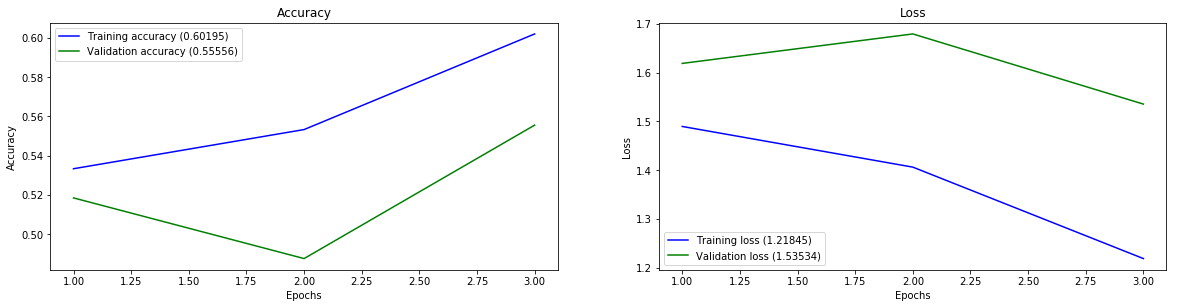

peak memory: 1234.22 MiB, increment: 6.24 MiB
Wall time: 1.05 s


In [414]:
%%time
%%memit

import matplotlib.pyplot as plt
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [415]:
#Evaludate model use Keras reported accuracy:
score = model.evaluate(X_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(X_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  74.0 %
model test data score        :  66.0 %
model validation data score  :  56.0 %


In [374]:
print ("Prediction with [train] data")
y_pred = model.predict_classes(X_train)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_train[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(5):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_train[i])])
    print ("")

Prediction with [train] data
  |__match    : 890
  |__miss     : 1538
  |__accuracy : -72.81 %

---samples---
0 predict = ../CatSound_dataset/Angry/Cat_Angry1026.mp3
0 original= ../CatSound_dataset/Angry/Cat_Angry1026.mp3

1 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
1 original= ../CatSound_dataset/Angry/Cat_Angry1031.mp3

2 predict = ../CatSound_dataset/Angry/Cat_Angry1032.mp3
2 original= ../CatSound_dataset/Angry/Cat_Angry1032.mp3

3 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
3 original= ../CatSound_dataset/Angry/Cat_Angry1030.mp3

4 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
4 original= ../CatSound_dataset/Angry/Cat_Angry1031.mp3



In [375]:
# prediction class 
print ("Prediction with [test] data")
y_pred = model.predict_classes(X_test)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_test[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(8):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_test[i])])
    print ("")

Prediction with [test] data
  |__match    : 78
  |__miss     : 111
  |__accuracy : -42.31 %

---samples---
0 predict = ../CatSound_dataset/Angry/Cat_Angry1033.mp3
0 original= ../CatSound_dataset/Angry/Cat_Angry1033.mp3

1 predict = ../CatSound_dataset/Angry/Cat_Angry1035.mp3
1 original= ../CatSound_dataset/Angry/Cat_Angry1034.mp3

2 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
2 original= ../CatSound_dataset/Angry/Cat_Angry1030.mp3

3 predict = ../CatSound_dataset/Angry/Cat_Angry1034.mp3
3 original= ../CatSound_dataset/Angry/Cat_Angry1034.mp3

4 predict = ../CatSound_dataset/Angry/Cat_Angry1033.mp3
4 original= ../CatSound_dataset/Angry/Cat_Angry1033.mp3

5 predict = ../CatSound_dataset/Angry/Cat_Angry1027.mp3
5 original= ../CatSound_dataset/Angry/Cat_Angry1027.mp3

6 predict = ../CatSound_dataset/Angry/Cat_Angry1029.mp3
6 original= ../CatSound_dataset/Angry/Cat_Angry1029.mp3

7 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
7 original= ../CatSound_dataset/Angry/Cat_Angr

In [376]:
# prediction class 
print ("Prediction with [validation] data")
y_pred = model.predict_classes(X_val)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_val[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(8):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_val[i])])
    print ("")

Prediction with [validation] data
  |__match    : 35
  |__miss     : 46
  |__accuracy : -31.43 %

---samples---
0 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
0 original= ../CatSound_dataset/Angry/Cat_Angry1031.mp3

1 predict = ../CatSound_dataset/Angry/Cat_Angry1033.mp3
1 original= ../CatSound_dataset/Angry/Cat_Angry1032.mp3

2 predict = ../CatSound_dataset/Angry/Cat_Angry1027.mp3
2 original= ../CatSound_dataset/Angry/Cat_Angry1027.mp3

3 predict = ../CatSound_dataset/Angry/Cat_Angry1029.mp3
3 original= ../CatSound_dataset/Angry/Cat_Angry1029.mp3

4 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
4 original= ../CatSound_dataset/Angry/Cat_Angry1033.mp3

5 predict = ../CatSound_dataset/Angry/Cat_Angry1033.mp3
5 original= ../CatSound_dataset/Angry/Cat_Angry1026.mp3

6 predict = ../CatSound_dataset/Angry/Cat_Angry1032.mp3
6 original= ../CatSound_dataset/Angry/Cat_Angry1031.mp3

7 predict = ../CatSound_dataset/Angry/Cat_Angry1031.mp3
7 original= ../CatSound_dataset/Angry/Cat

In [288]:
print ("test data size ",len(test_audio_data))
sub_test = test_audio_data[1:22]
tx_test, ty_test = zip(*test_audio_data)

# make prediction 
tx_test2 = np.array([x.reshape((128, 128, 1)) for x in tx_test])
print ("test data shape ", tx_test2.shape)

test data size  110
test data shape  (110, 128, 128, 1)


In [289]:
# run prediction data
y_pred = model.predict_classes(tx_test2, batch_size=1)
print ( len(y_pred), len(tx_test2))

110 110


In [291]:
# save result for submission
prediction_output_file='prediction_result_1.csv'
with open(prediction_output_file,"w") as file:
    file.write("ID,Prediction\n") 
    i=0
    for i in range( (len(valid_test_data)-1)) :
        #print(i, y_pred[i])
        file.write(str(valid_test_data['label'][i])+','+ int_to_label[y_pred[i]])
        file.write('\n')
        i=i+1
        
print (len(y_pred))
output = pd.read_csv(prediction_output_file)
output.head(20)

110


,ID,Prediction
0,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
1,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
2,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
3,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
4,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
5,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
6,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
7,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
8,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
9,0,../CatSound_dataset/Angry/Cat_Angry1026.mp3
